# 📊 Superstore Sales Analysis

## Business Problem
Despite revenue growth, Superstore is suffering from sales inefficiencies due to a reactive, "one-size-fits-all" strategy. Without visibility into product-level performance, regional managers are applying blanket discounts that may be unnecessary for high-demand items or ill-timed for slow-moving inventory.

## Business Question
How can we optimize revenue through targeted discounts by aligning product-level strategies with regional sales performance and seasonal demand patterns? Specifically, we need to answer three core decision dimensions:

1. **Where**: Which regions offer the highest concentration of sales and should be prioritized?
2. **Which**: What product strategies should be employed at a granular level?
3. **When**: How does seasonality affect product demand, and when should discounts be deployed?

## Dataset & Methodology

The analysis leverages the **Global Superstore dataset**, which provides detailed transaction-level information on sales volume, order frequency, and regional performance. We developed a **5-quadrant product classification system** combined with seasonality mapping to create region-specific, data-driven discount and inventory strategies. 
The five product strategies are: **Star (Protect)**, **Luxury (Target)**, **Traffic Builder (Bundle)**, **Dead Zombie (Liquidate)**, and **New/Niche (Watch List)** - with the New/Niche category distinguishing recent products (less than 180 days on shelf) from true zombies.

In [101]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import linregress

## Import Libraries & Load Data

In [83]:
df = pd.read_csv('train.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


## Data Preprocessing

In [84]:
print(df.info())
print(f"Missing Postal Codes: {df['Postal Code'].isnull().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [85]:
# Drop Postal Code (too many missing values) and Country (all USA)
df = df.drop(['Postal Code', 'Country'], axis=1)
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Region',
       'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales'],
      dtype='object')

In [86]:
print(f"States: {df['State'].nunique()}")
print(f"Regions: {df['Region'].unique()}")
print(f"Categories: {df['Category'].nunique()}, Sub-Categories: {df['Sub-Category'].nunique()}, Products: {df['Product Name'].nunique()}")

States: 49
Regions: ['South' 'West' 'Central' 'East']
Categories: 3, Sub-Categories: 17, Products: 1849


In [87]:
# Convert dates and shift years (2014-2017 → 2022-2025)
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')

year_shift = 7
df['Order Date'] = df['Order Date'] + pd.DateOffset(years=year_shift)
df['Ship Date'] = df['Ship Date'] + pd.DateOffset(years=year_shift)

# Extract temporal features
df['Order_Year'] = df['Order Date'].dt.year
df['Order_Month_Num'] = df['Order Date'].dt.month
df['Order_Day'] = df['Order Date'].dt.day
df['Order_Day_Of_Week'] = df['Order Date'].dt.dayofweek

# Map to readable names
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['Order_Day_Of_Week'] = df['Order_Day_Of_Week'].map(day_mapping)

month_mapping = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 
                 5: 'May', 6: 'June', 7: 'July', 8: 'August', 
                 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
df['Order_Month'] = df['Order_Month_Num'].map(month_mapping)

df['Order_Quarter'] = df['Order_Month_Num'].apply(lambda x: ((x-1)//3)+1)
df['Order_Week']= ((df['Order Date'] - df['Order Date'].min()).dt.days // 7) + 1

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Sub-Category,Product Name,Sales,Order_Year,Order_Month_Num,Order_Day,Order_Day_Of_Week,Order_Month,Order_Quarter,Order_Week
0,1,CA-2017-152156,2024-11-08,2024-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,...,Bookcases,Bush Somerset Collection Bookcase,261.9600,2024,11,8,Friday,November,4,149
1,2,CA-2017-152156,2024-11-08,2024-11-11,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,...,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,2024,11,8,Friday,November,4,149
2,3,CA-2017-138688,2024-06-12,2024-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,Los Angeles,California,...,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2024,6,12,Wednesday,June,2,128
3,4,US-2016-108966,2023-10-11,2023-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,...,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,2023,10,11,Wednesday,October,4,93
4,5,US-2016-108966,2023-10-11,2023-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,...,Storage,Eldon Fold 'N Roll Cart System,22.3680,2023,10,11,Wednesday,October,4,93


In [88]:
# Data quality checks
print(f"Duplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()

print(f"Negative Sales: {(df['Sales'] < 0).sum()}")
print(f"Invalid ship dates: {(df['Ship Date'] < df['Order Date']).sum()}")

Duplicate rows: 0
Negative Sales: 0
Invalid ship dates: 0


In [89]:
df.to_csv('train_clean.csv', index=False)

## Exploratory Data Analysis (EDA)

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\4240107117.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=yearly_sales, x='Order Date', y='Sales', palette='Blues_d')


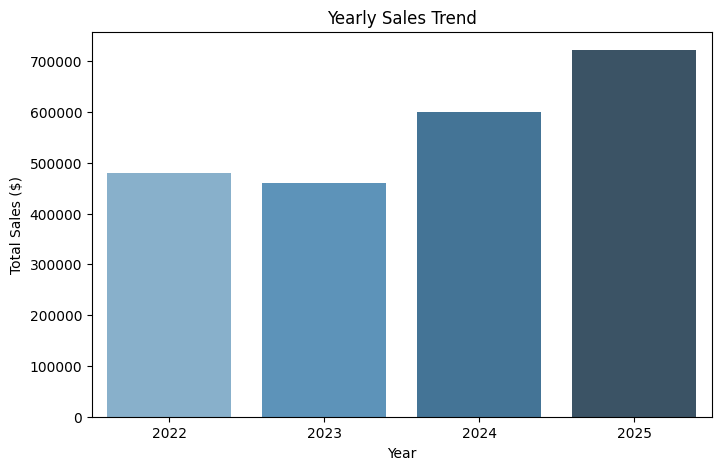

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\4240107117.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=quarterly_sales, x='Order_Quarter', y='Sales', palette='Greens_d')


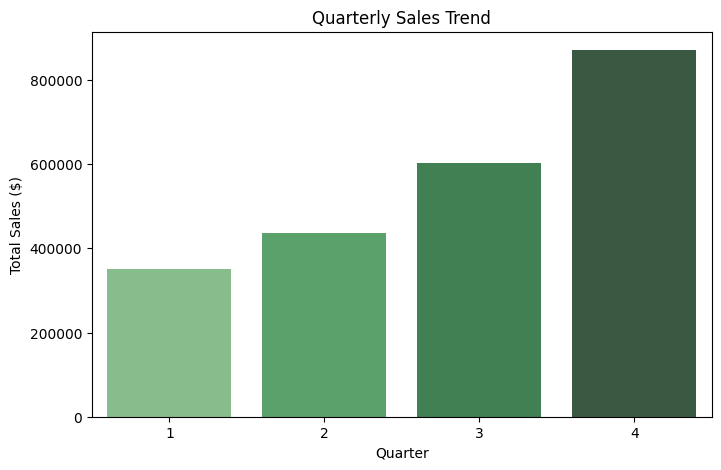

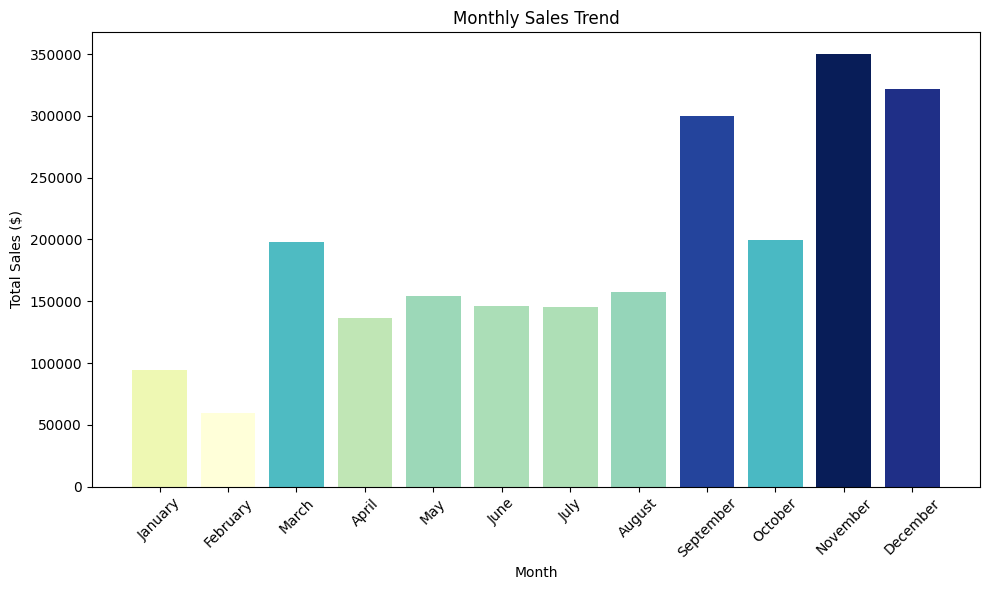

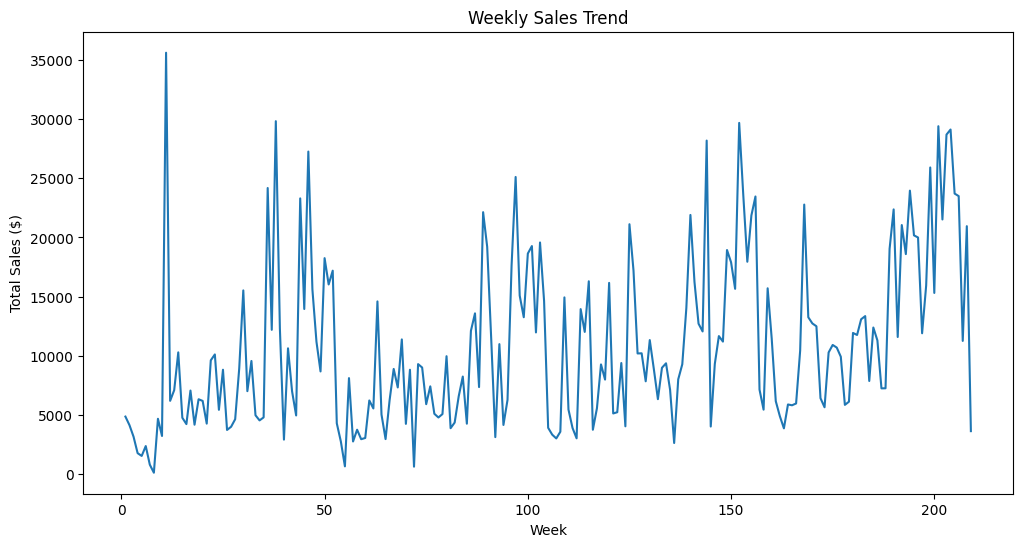

In [90]:
# Yearly Sales Trend
yearly_sales = df.groupby(df['Order Date'].dt.year)['Sales'].sum().reset_index()
yearly_sales['YoY_Growth'] = yearly_sales['Sales'].pct_change() * 100

plt.figure(figsize=(8, 5))
sns.barplot(data=yearly_sales, x='Order Date', y='Sales', palette='Blues_d')
plt.title('Yearly Sales Trend')
plt.xlabel('Year')
plt.ylabel('Total Sales ($)')
plt.show()

# Quarterly Sales Trend
quarterly_sales = df.groupby(df['Order_Quarter'])['Sales'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=quarterly_sales, x='Order_Quarter', y='Sales', palette='Greens_d')
plt.title('Quarterly Sales Trend')
plt.xlabel('Quarter')
plt.ylabel('Total Sales ($)')
plt.show()

# Monthly Sales Trend
monthly_sales = df.groupby(['Order_Month_Num', 'Order_Month'])['Sales'].sum().reset_index()
monthly_sales = monthly_sales.sort_values('Order_Month_Num')

plt.figure(figsize=(10, 6))
colors = plt.cm.YlGnBu((monthly_sales['Sales'] - monthly_sales['Sales'].min()) / 
                        (monthly_sales['Sales'].max() - monthly_sales['Sales'].min()))
plt.bar(monthly_sales['Order_Month'], monthly_sales['Sales'], color=colors, edgecolor='none')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.ylabel('Total Sales ($)')
plt.tight_layout()
plt.show()

# Weekly Sales Trend
weekly_sales = df.groupby(df['Order_Week'])['Sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_sales, x='Order_Week', y='Sales')
plt.title('Weekly Sales Trend')
plt.xlabel('Week')
plt.ylabel('Total Sales ($)')
plt.show()

### 📊 Sales Performance Insights

**Yearly Trend:** Steady growth from 2022 to 2025 with a slight dip in 2023, indicating consistent revenue expansion and market recovery.

**Quarterly Patterns:** Q4 consistently outperforms other quarters (holiday shopping), while Q1 shows the lowest sales (post-holiday seasonal dip).

**Monthly Peaks:** September, November, and December show the highest sales—driven by back-to-school, Thanksgiving, and holiday shopping seasons.

**Weekly Volatility:** Significant week-to-week fluctuations suggest promotional activity and demand spikes throughout the year.

📈 WEEKLY SALES TREND ANALYSIS
Average Weekly Sales Increase: $45.28 per week
R²: 0.1468 (14.68%)
Statistical Significance (p-value): 0.000000


📈 WEEKLY SALES TREND ANALYSIS
Average Weekly Sales Increase: $45.28 per week
R²: 0.1468 (14.68%)
Statistical Significance (p-value): 0.000000


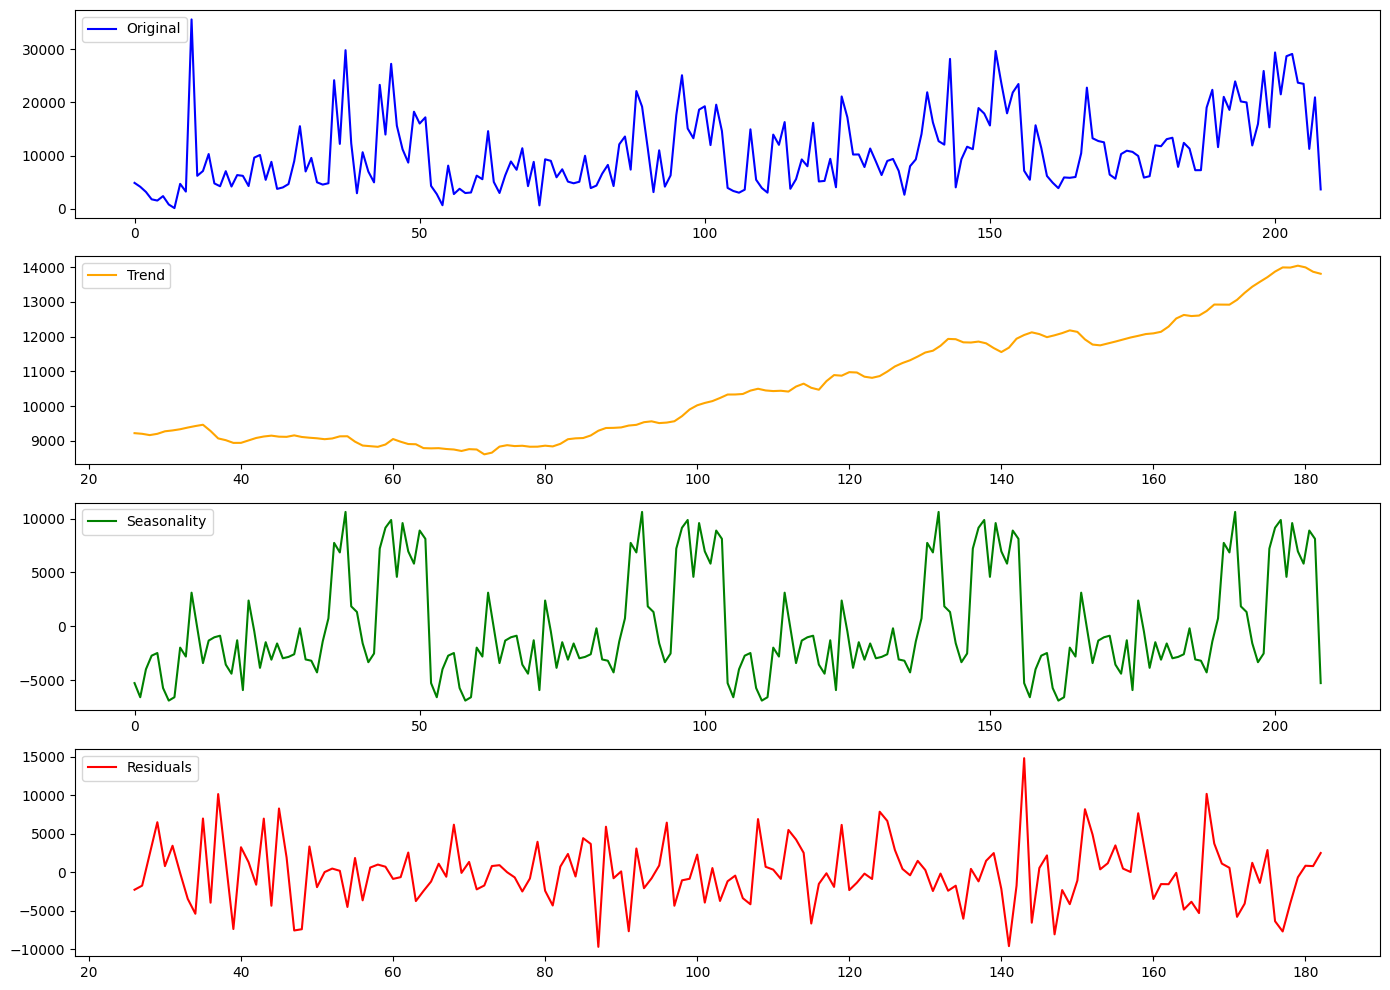

In [91]:
# Decompose weekly sales for trend and seasonality
decomposition = seasonal_decompose(weekly_sales['Sales'], model='additive', period=52)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Linear regression on weekly sales
slope, intercept, r_value, p_value, std_err = linregress(weekly_sales['Order_Week'], weekly_sales['Sales'])
print("📈 WEEKLY SALES TREND ANALYSIS")
print(f"Average Weekly Sales Increase: ${slope:,.2f} per week")
print(f"R²: {r_value**2:.4f} ({r_value**2*100:.2f}%)")
print(f"Statistical Significance (p-value): {p_value:.6f}")

plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(weekly_sales['Sales'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

    Region        Sales
0  Central  492646.9132
1     East  669518.7260
2    South  389151.4590
3     West  710219.6845


C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\799885166.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_region, x='Region', y='Sales', palette='Set2')


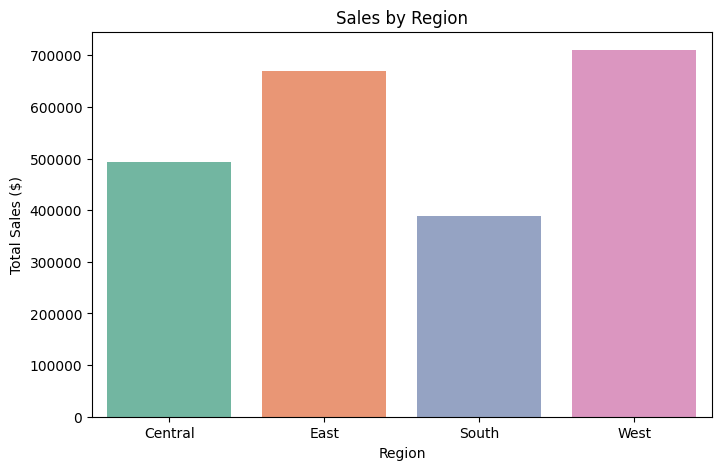

In [62]:
sales_by_region = df.groupby('Region')['Sales'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=sales_by_region, x='Region', y='Sales', palette='Set2')
plt.title('Sales by Region')
plt.xlabel('Region')
plt.ylabel('Total Sales ($)')
plt.show()

### 🌎 Regional Performance

The West region leads in total sales, indicating strong market presence. The Central region lags behind, presenting growth opportunities through targeted marketing strategies.

          Category        Sales
0        Furniture  728658.5757
1  Office Supplies  705422.3340
2       Technology  827455.8730
   Sub-Category        Sales
13       Phones  327782.4480
5        Chairs  322822.7310
14      Storage  219343.3920
16       Tables  202810.6280
3       Binders  200028.7850
11     Machines  189238.6310
0   Accessories  164186.7000
6       Copiers  146248.0940
4     Bookcases  113813.1987
1    Appliances  104618.4030
9   Furnishings   89212.0180
12        Paper   76828.3040
15     Supplies   46420.3080
2           Art   26705.4100
7     Envelopes   16128.0460
10       Labels   12347.7260
8     Fasteners    3001.9600
                                        Product Name      Sales
0              Canon imageCLASS 2200 Advanced Copier  61599.824
1  Fellowes PB500 Electric Punch Plastic Comb Bin...  27453.384
2  Cisco TelePresence System EX90 Videoconferenci...  22638.480
3       HON 5400 Series Task Chairs for Big and Tall  21870.576
4         GBC DocuBind TL300 E

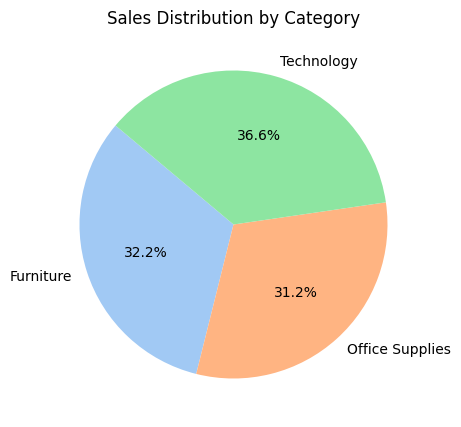

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\514694177.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_subcategory, x='Sub-Category', y='Sales', palette='Set3')


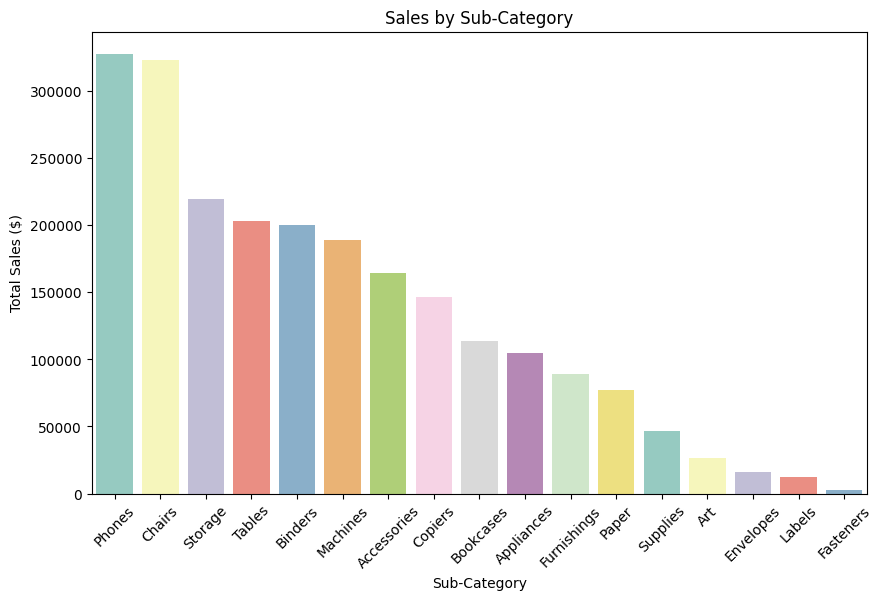

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\514694177.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_product, x='Sales', y='Product Name', palette='Blues_d')


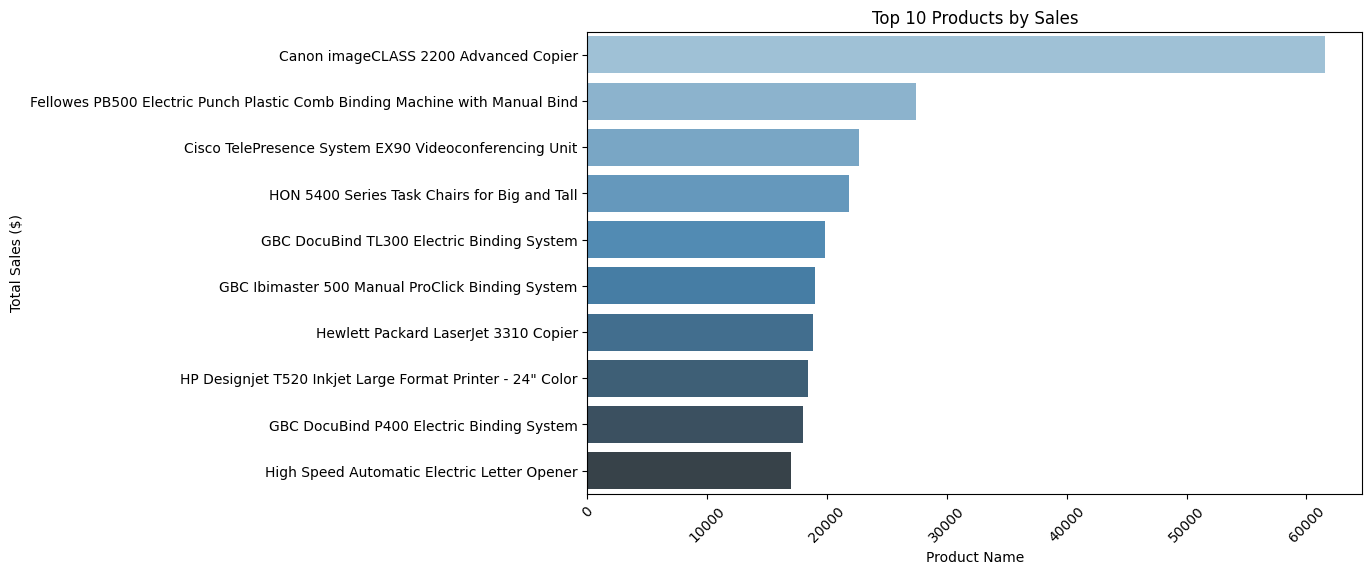

In [63]:
sales_by_category = df.groupby('Category')['Sales'].sum().reset_index()
sales_by_subcategory = df.groupby('Sub-Category')['Sales'].sum().reset_index().sort_values(by='Sales', ascending=False)
sales_by_product = df.groupby('Product Name')['Sales'].sum().sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(8, 5))
plt.pie(sales_by_category['Sales'], labels=sales_by_category['Category'], autopct='%1.1f%%', 
        startangle=140, colors=sns.color_palette('pastel'))
plt.title('Sales Distribution by Category')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=sales_by_subcategory, x='Sub-Category', y='Sales', palette='Set3')
plt.title('Sales by Sub-Category')
plt.xlabel('Sub-Category')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=sales_by_product, x='Sales', y='Product Name', palette='Blues_d')
plt.title('Top 10 Products by Sales')
plt.xlabel('Sales ($)')
plt.ylabel('Product Name')
plt.show()

### 📦 Product Portfolio Analysis

**Category Distribution:** Balanced revenue across Technology (36.4%), Furniture (32.3%), and Office Supplies (31.3%)—diversification reduces business risk.

**Top Sub-Categories:** Phones and Chairs collectively account for ~30% of total revenue, making them strategic focus areas for inventory and promotions.

**Star Product:** Canon imageCLASS 2200 Advanced Copier is the highest revenue-generating SKU, warranting priority stock optimization.

## Regional Deep-Dive Analysis

   Order Date       Sales
0        2022  127652.819
1        2023  153225.183
2        2024  178511.538
3        2025  210129.186


C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\2373893265.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=east_yearly_sales, x='Order Date', y='Sales',


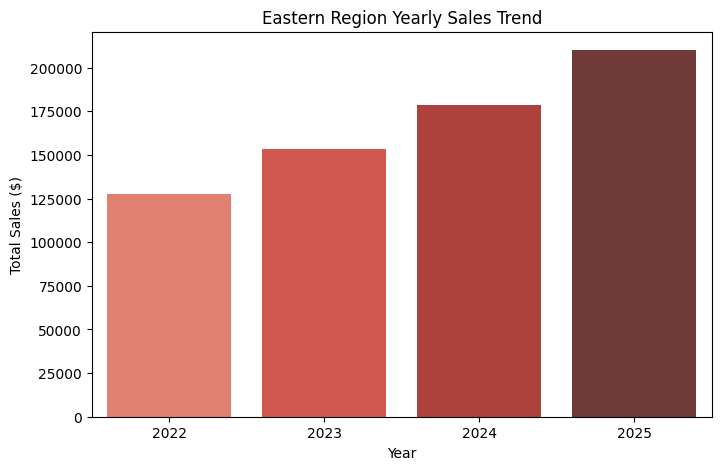

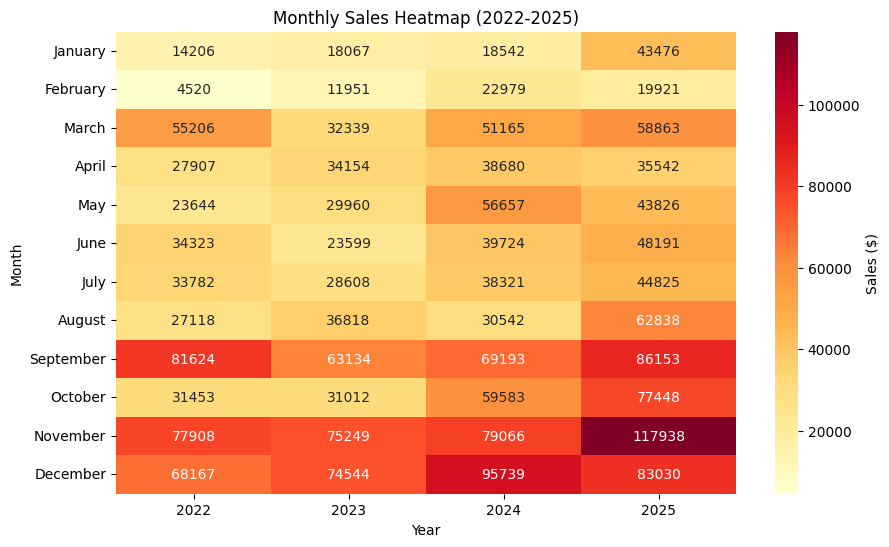

                     mean           std         CV
Order_Month                                       
April        34070.750150   4524.303265  13.279142
September    75025.852925  10689.299327  14.247488
December     80370.042375  11918.420660  14.829432
July         36383.922250   6885.692791  18.925098
November     87540.427750  20328.050580  23.221329
March        49393.396800  11796.123320  23.881984
June         36459.380825  10299.346016  28.248823
May          38521.680925  14738.485527  38.260235
August       39328.981750  16179.174131  41.138045
October      49874.073675  22728.115790  45.571003
February     14842.778850   8304.725338  55.951284
January      23572.907400  13410.406147  56.889063


C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\2373893265.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_stability_sorted.reset_index(), x='Order_Month', y='CV', palette='coolwarm')


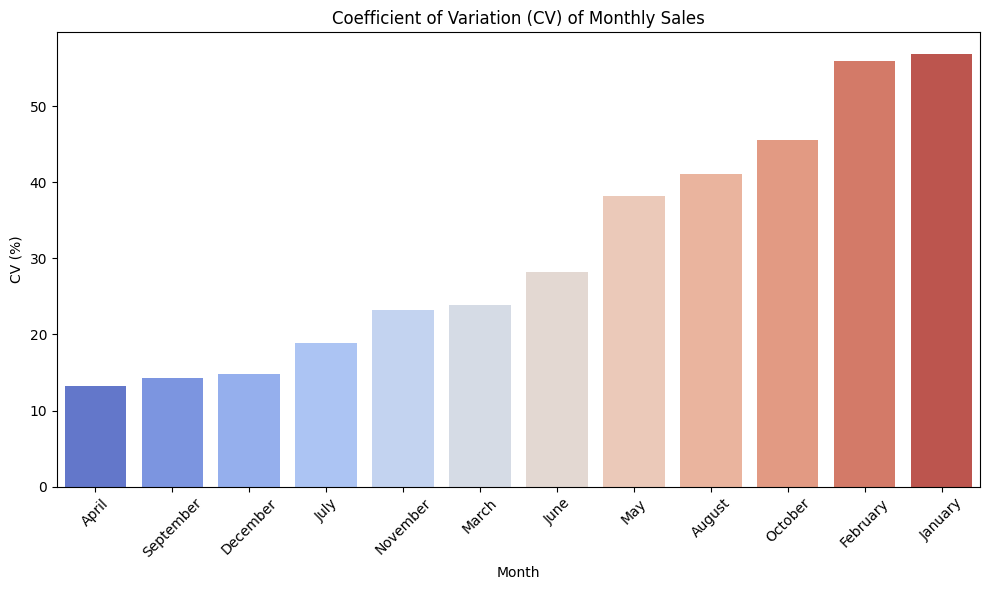

In [64]:
# East Region Performance
east = df[df['Region'] == 'East']
east_yearly_sales = east.groupby(east['Order Date'].dt.year)['Sales'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=east_yearly_sales, x='Order Date', y='Sales', palette='Reds_d')
plt.title('Eastern Region Yearly Sales Trend')
plt.xlabel('Year')
plt.ylabel('Total Sales ($)')
plt.show()

# Seasonal heatmap analysis
monthly_sales = df.groupby(['Order_Year', 'Order_Month_Num', 'Order_Month'])['Sales'].sum().reset_index()
heatmap_data = monthly_sales.pivot(index='Order_Month', columns='Order_Year', values='Sales')

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
heatmap_data = heatmap_data.reindex(month_order)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=0.5)
plt.title('Monthly Sales Heatmap (All Regions)')
plt.xlabel('Year')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

# Coefficient of variation analysis
monthly_stability = monthly_sales.groupby('Order_Month')['Sales'].agg(['std', 'mean']).reset_index()
monthly_stability['CV'] = (monthly_stability['std'] / monthly_stability['mean']) * 100
monthly_stability = monthly_stability.set_index('Order_Month')

monthly_stability_sorted = monthly_stability.sort_values('CV')
plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_stability_sorted.reset_index(), x='Order_Month', y='CV', palette='coolwarm')
plt.title('Coefficient of Variation (CV) of Monthly Sales')
plt.xlabel('Month')
plt.ylabel('CV (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 🔴 East Region Insights

**Yearly Growth:** Consistent upward trend from 2022 to 2025, indicating strong market response to sales strategies.

**Seasonality:** Low CV months (<30%) show consistent year-over-year patterns, ideal for forecasting. High CV months (>30%) indicate promotional influence and variability.

                   State       Sales  Proportion
8               New York  306361.147   45.758413
10          Pennsylvania  116276.650   17.367199
9                   Ohio   75130.350   11.221546
7             New Jersey   34610.972    5.169530
5          Massachusetts   28634.434    4.276868
1               Delaware   27322.999    4.080991
4               Maryland   23705.523    3.540681
11          Rhode Island   22525.026    3.364361
0            Connecticut   13384.357    1.999101
12               Vermont    8929.370    1.333700
6          New Hampshire    7292.524    1.089219
2   District of Columbia    2865.020    0.427922
3                  Maine    1270.530    0.189768
13         West Virginia    1209.824    0.180701


C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\3414549138.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=east_sales_by_state, x='State', y='Sales', palette='Reds_d')


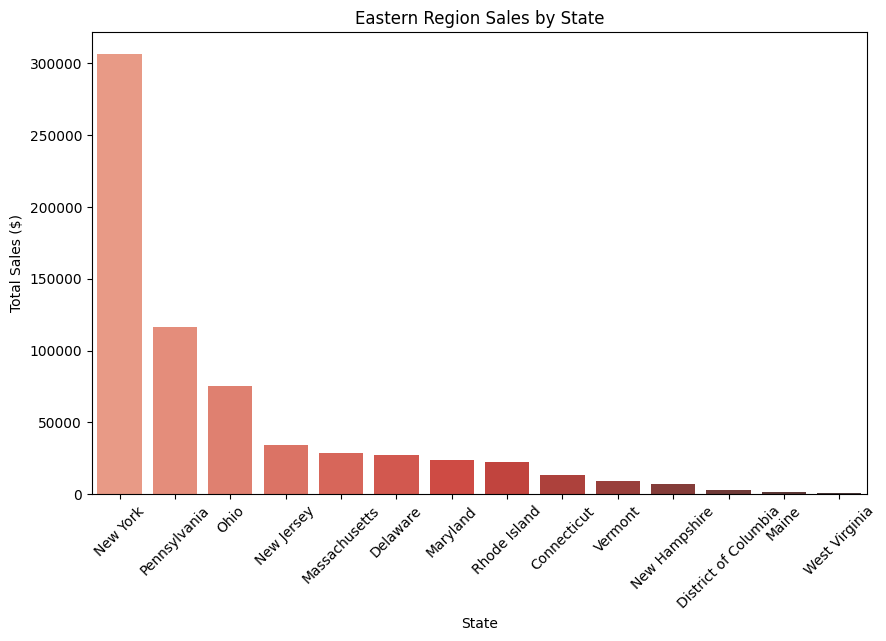

             City       Sales
72  New York City  252462.547
82   Philadelphia  108841.749
73         Newark   28448.049
46       Lakewood   16599.424
84     Providence   15980.650
..            ...         ...
28        Danbury      27.460
4   Atlantic City      23.360
2         Altoona      20.451
70  New Brunswick      14.770
32         Elyria       1.824

[107 rows x 2 columns]


C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\3414549138.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=east_sales_by_cities.head(10), x='City', y='Sales', palette='Reds_d')


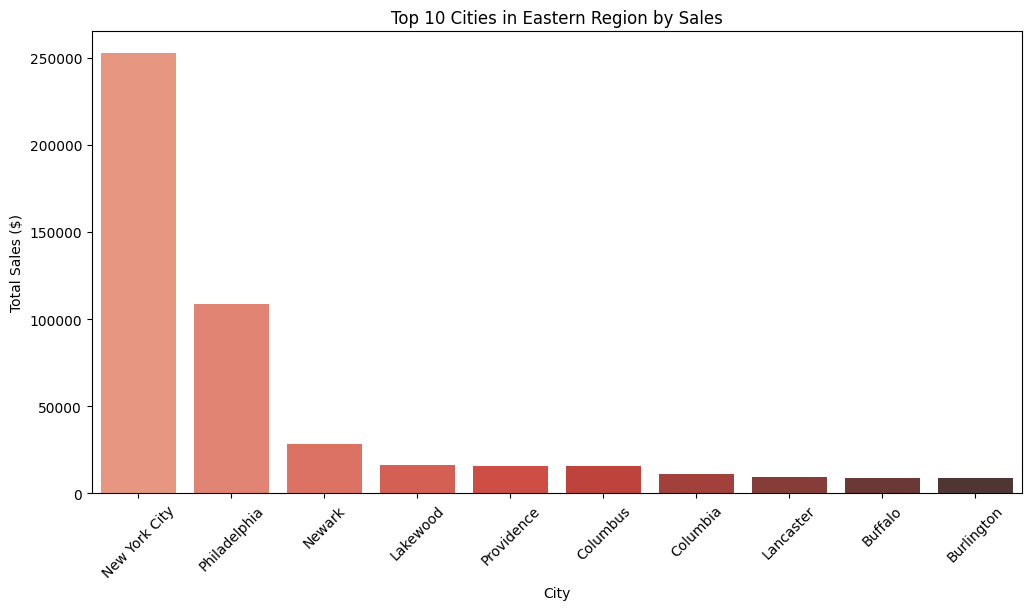

In [65]:
east_sales_by_state = east.groupby('State')['Sales'].sum().reset_index().sort_values(by='Sales', ascending=False)
east_sales_by_state['Proportion'] = (east_sales_by_state['Sales'] / east_sales_by_state['Sales'].sum()) * 100

plt.figure(figsize=(10, 6))
sns.barplot(data=east_sales_by_state, x='State', y='Sales', palette='Reds_d')
plt.title('Eastern Region Sales by State')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.ylabel('Total Sales ($)')
plt.show()

east_sales_by_cities = east.groupby('City')['Sales'].sum().reset_index().sort_values(by='Sales', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=east_sales_by_cities.head(10), x='City', y='Sales', palette='Reds_d')
plt.title('Top 10 Cities in Eastern Region by Sales')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.ylabel('Total Sales ($)')
plt.show()

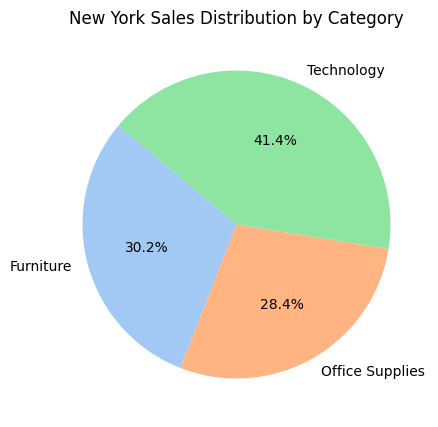

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\485860255.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ny_sales_by_subcategory, x='Sub-Category', y='Sales', palette='Set3')


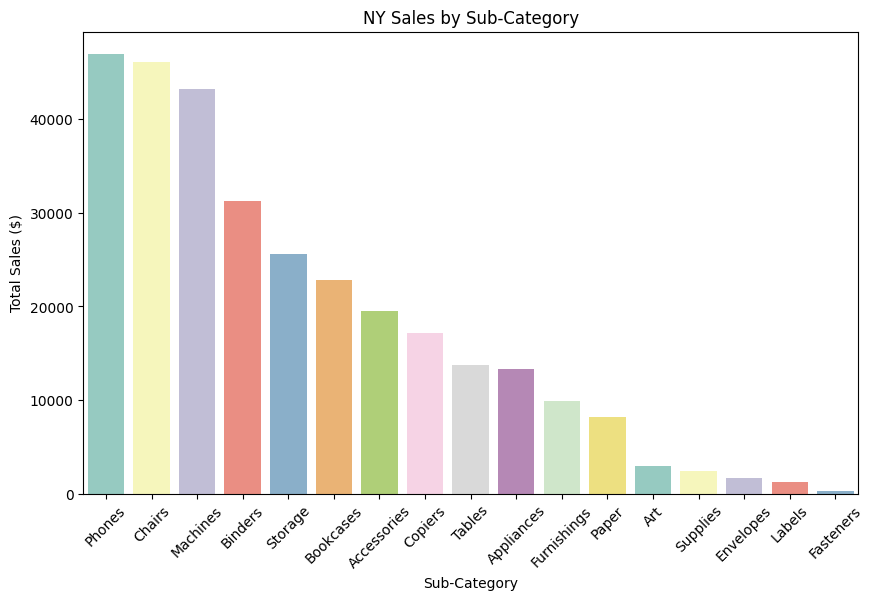

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\485860255.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ny_sales_by_product, x='Sales', y='Product Name', palette='Reds_d')


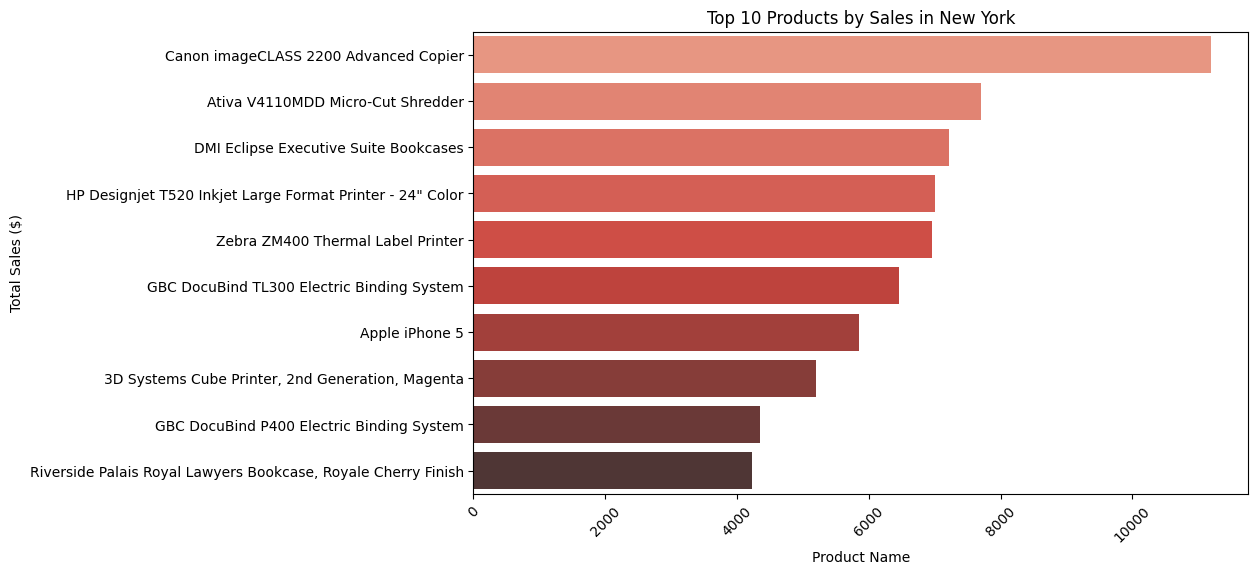

In [105]:
# Focus on New York (45%+ of East region sales)
ny = east[east['State'] == 'New York']

ny_sales_by_category = ny.groupby('Category')['Sales'].sum().reset_index()
ny_sales_by_subcategory = ny.groupby('Sub-Category')['Sales'].sum().reset_index().sort_values(by='Sales', ascending=False)
ny_sales_by_product = ny.groupby('Product Name')['Sales'].sum().sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(8, 5))
plt.pie(ny_sales_by_category['Sales'], labels=ny_sales_by_category['Category'], 
        autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('New York Sales Distribution by Category')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=ny_sales_by_subcategory, x='Sub-Category', y='Sales', palette='Set3')
plt.title('NY Sales by Sub-Category')
plt.xlabel('Sub-Category')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=ny_sales_by_product, x='Sales', y='Product Name', palette='Reds_d')
plt.title('Top 10 Products by Sales in New York')
plt.xlabel('Product Name')
plt.xticks(rotation=45)
plt.ylabel('Total Sales ($)')
plt.show()

### 🗽 New York Market Insights

**Category Mix:** Technology dominates with 40.2%, followed by Furniture (30.5%) and Office Supplies (29.3%), prioritize tech inventory.

**Top Sub-Categories:** Phones and Chairs drive 30% of revenue, key areas for inventory management.

**Star SKU:** Canon imageCLASS 2200 Advanced Copier is the top revenue generator, requires priority stock optimization.

Max line items per Order-Product combo: 2



Max line items per Order-Product combo: 2



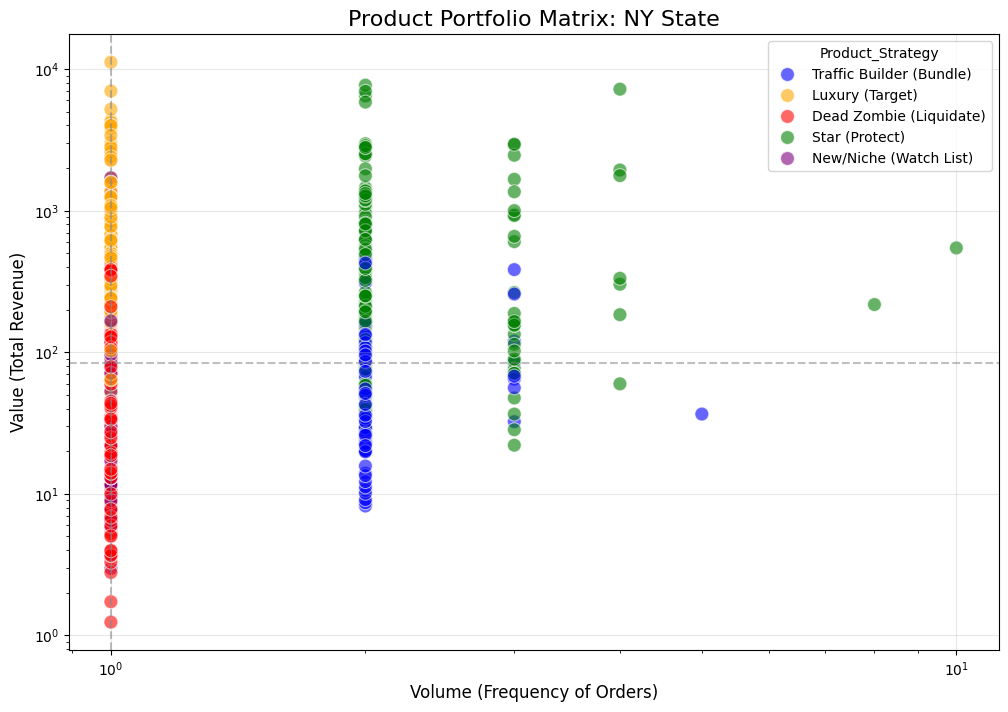

In [93]:
# Product Portfolio Matrix for NY
duplicates = df.groupby(['Order ID', 'Product ID']).size()
print(f"Max line items per Order-Product combo: {duplicates.max()}\n")

product_stats = ny.groupby(['Sub-Category', 'Product Name']).agg({
    'Sales': 'sum',
    'Row ID': 'count',
    'Order Date': 'max'
}).reset_index()
product_stats.columns = ['Sub-Category', 'Product Name', 'Total_Sales', 'Line_Item_Freq', 'Last_Sale_Date']

max_date = ny['Order Date'].max()
product_stats['Recency_Days'] = (max_date - product_stats['Last_Sale_Date']).dt.days

product_stats['Category_Median_Sales'] = product_stats.groupby('Sub-Category')['Total_Sales'].transform('median')
product_stats['Category_Median_Freq'] = product_stats.groupby('Sub-Category')['Line_Item_Freq'].transform('median')

def classify_strategy(row):
    high_val = row['Total_Sales'] >= row['Category_Median_Sales']
    high_vol = row['Line_Item_Freq'] > row['Category_Median_Freq']
    is_recent = row['Recency_Days'] <= 180
    
    if high_val and high_vol:
        return 'Star (Protect)'
    elif high_val and not high_vol:
        return 'Luxury (Target)'
    elif not high_val and high_vol:
        return 'Traffic Builder (Bundle)'
    else:
        if is_recent:
            return 'New/Niche (Watch List)'
        else:
            return 'Dead Zombie (Liquidate)'

product_stats['Product_Strategy'] = product_stats.apply(classify_strategy, axis=1)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=product_stats,
    x='Line_Item_Freq', 
    y='Total_Sales',
    hue='Product_Strategy',
    palette={'Star (Protect)': 'green', 
             'Dead Zombie (Liquidate)': 'red', 
             'Luxury (Target)': 'orange', 
             'Traffic Builder (Bundle)': 'blue',
             'New/Niche (Watch List)': 'purple'},
    alpha=0.6,
    s=100
)

plt.title('Product Portfolio Matrix: NY State', fontsize=16)
plt.xlabel('Volume (Frequency of Orders)', fontsize=12)
plt.ylabel('Value (Total Revenue)', fontsize=12)
plt.axvline(product_stats['Line_Item_Freq'].median(), color='grey', linestyle='--', alpha=0.5)
plt.axhline(product_stats['Total_Sales'].median(), color='grey', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.xscale('log') 
plt.yscale('log')
plt.show()

### 📊 NY Product Strategy

**Market Fragmentation:** 80% of catalog represents one-off purchases—shift focus from mass volume to high-value capture.

**Action Plan:**
- **Protect:** Star products, no discounts or bundle with New/Niche products for exposure
- **Target:** Luxury items (low frequency, high value), tailored promotions and exclusive service
- **Bundle:** Traffic builders, use in cross-sell strategies, preferably with New/Niche products
- **Monitor:** New/Niche products after 360+days and work on reclassification
- **Liquidate:** Dead Zombies (old + low sales)- aggressive clearance

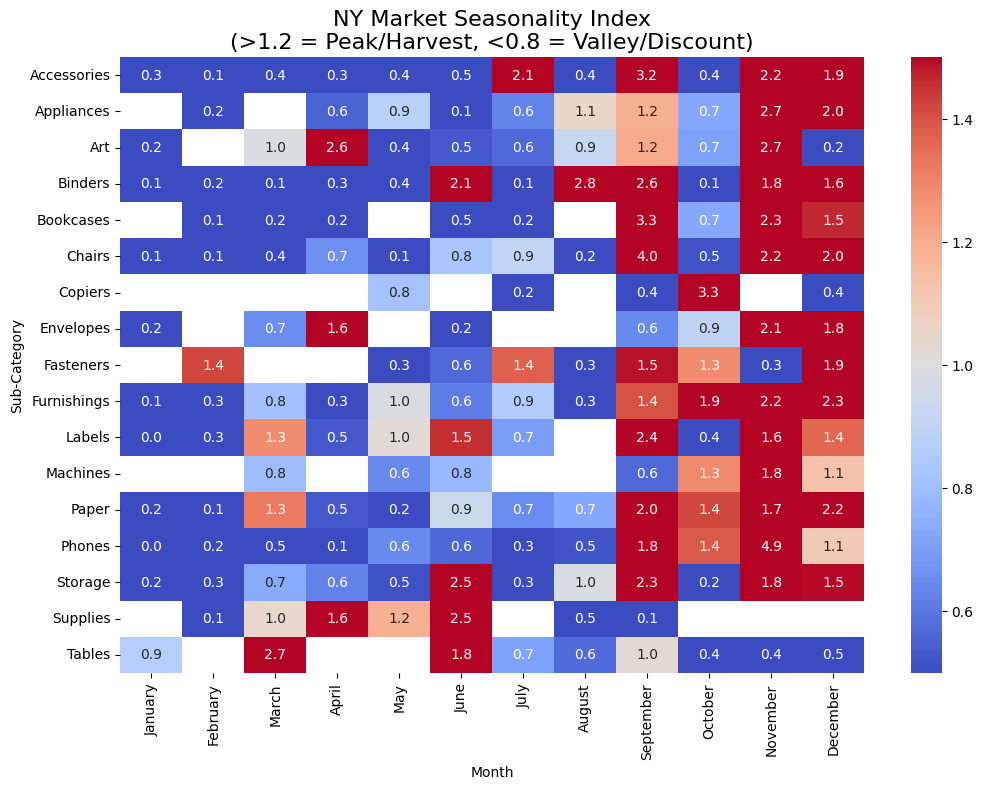

In [95]:
# Seasonality Analysis for NY
monthly_sales = ny.groupby(['Sub-Category','Order_Month_Num', 'Order_Month'])['Sales'].sum().reset_index()
monthly_sales['Avg_Sales'] = monthly_sales.groupby('Sub-Category')['Sales'].transform('mean')
monthly_sales['Seasonality_Index'] = monthly_sales['Sales'] / monthly_sales['Avg_Sales']

heatmap_data = monthly_sales.pivot(index='Sub-Category', columns='Order_Month', values='Seasonality_Index')

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
heatmap_data = heatmap_data.reindex(columns=month_order)

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data, 
    annot=True,
    fmt=".1f",
    cmap="coolwarm",
    center=1.0,
    vmin=0.5, vmax=1.5
)

plt.title('NY Market Seasonality Index\n(>1.2 = Peak/Harvest, <0.8 = Valley/Discount)', fontsize=16)
plt.ylabel('Sub-Category')
plt.xlabel('Month')
plt.show()

## West Region Analysis

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\3164176456.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=west_yearly_sales, x='Order Date', y='Sales', palette='Greens_d')


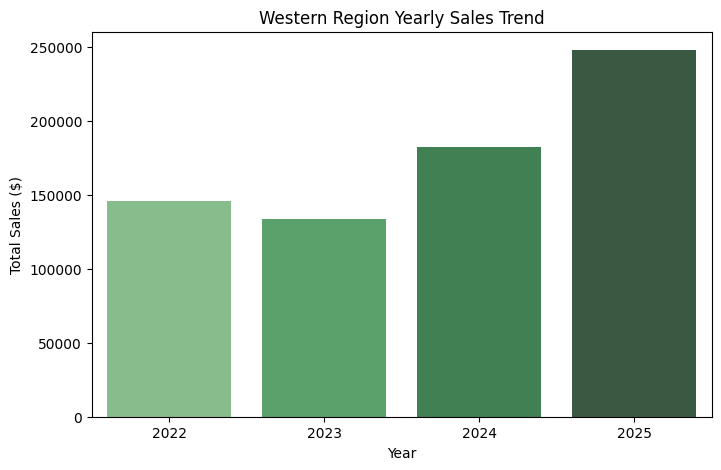

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\3164176456.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=west_yearly_sales, x='Order Date', y='Sales', palette='Greens_d')


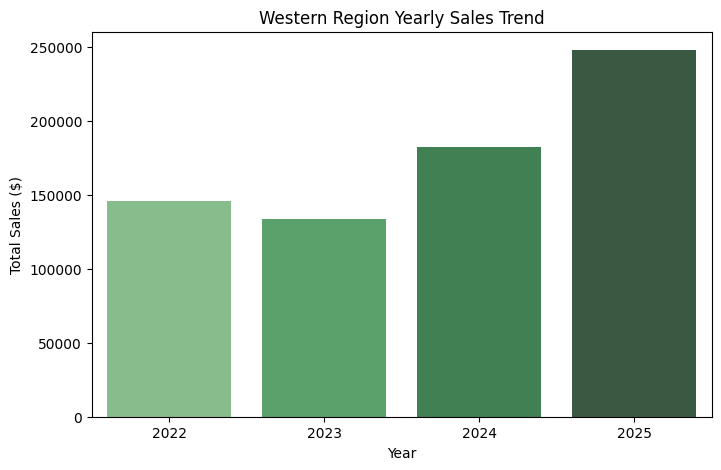

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\3164176456.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=west_sales_by_state, x='State', y='Sales', palette='Greens_d')


C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\3164176456.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=west_yearly_sales, x='Order Date', y='Sales', palette='Greens_d')


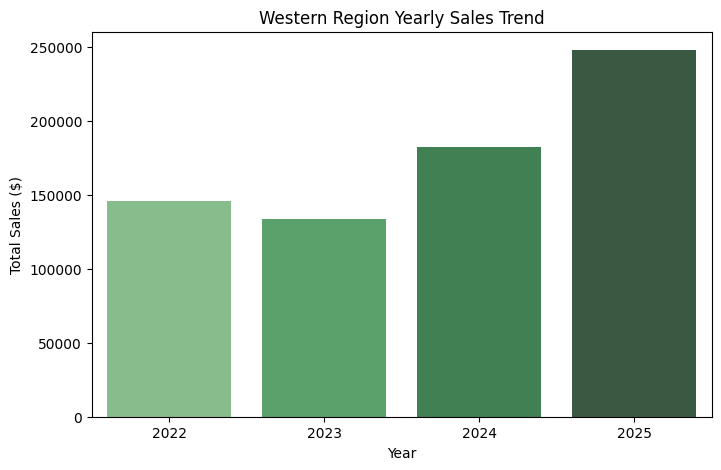

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\3164176456.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=west_sales_by_state, x='State', y='Sales', palette='Greens_d')


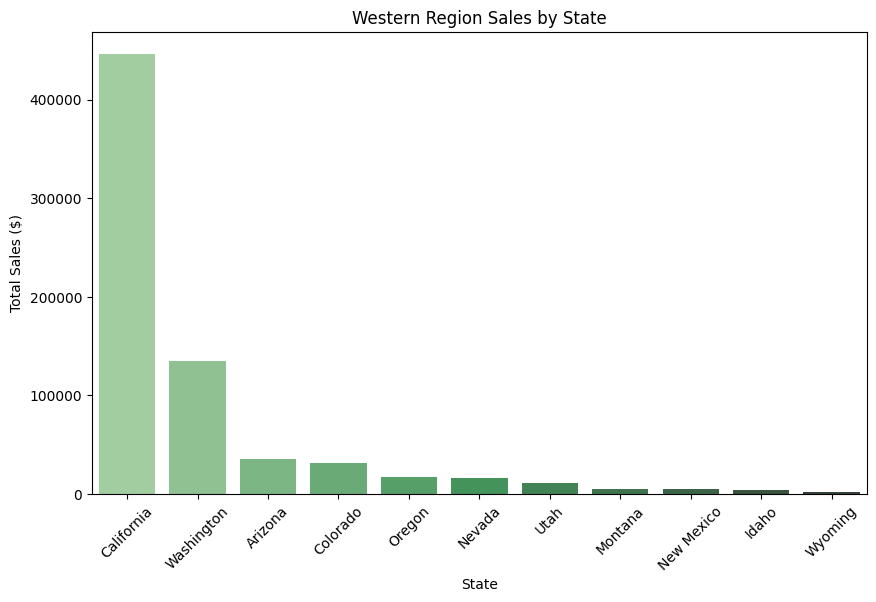

Top State: California ($446,306.46)
2nd State: Washington ($135,206.85)
Ratio: 30.29%

→ Analyzing only California


In [96]:
west = df[df['Region'] == 'West']
west_yearly_sales = west.groupby(west['Order Date'].dt.year)['Sales'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=west_yearly_sales, x='Order Date', y='Sales', palette='Greens_d')
plt.title('Western Region Yearly Sales Trend')
plt.xlabel('Year')
plt.ylabel('Total Sales ($)')
plt.show()

west_sales_by_state = west.groupby('State')['Sales'].sum().reset_index().sort_values(by='Sales', ascending=False)
west_sales_by_state['Proportion'] = (west_sales_by_state['Sales'] / west_sales_by_state['Sales'].sum()) * 100

plt.figure(figsize=(10, 6))
sns.barplot(data=west_sales_by_state, x='State', y='Sales', palette='Greens_d')
plt.title('Western Region Sales by State')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.ylabel('Total Sales ($)')
plt.show()

# Kingmaker Rule: Select focus states
top_state = west_sales_by_state.iloc[0]
second_state = west_sales_by_state.iloc[1]
ratio = second_state['Sales'] / top_state['Sales']

print(f"Top State: {top_state['State']} (${top_state['Sales']:,.2f})")
print(f"2nd State: {second_state['State']} (${second_state['Sales']:,.2f})")
print(f"Ratio: {ratio:.2%}\n")

if ratio >= 0.8:
    print(f"→ Analyzing both {top_state['State']} and {second_state['State']}")
    west_focus = west[west['State'].isin([top_state['State'], second_state['State']])]
    focus_label = f"{top_state['State']} + {second_state['State']}"
else:
    print(f"→ Analyzing only {top_state['State']}")
    west_focus = west[west['State'] == top_state['State']]
    focus_label = top_state['State']

### Strategic Product Classification - West Focus States

STRATEGIC PRODUCT MATRIX: California

STAR (PROTECT) (308 products):
  • Enermax Briskie RF Wireless Keyboard and Mouse Com: $228 | 2 orders | 33 days ago
  • Imation Clip USB flash drive - 8 GB: $188 | 2 orders | 581 days ago
  • Kensington Expert Mouse Optical USB Trackball for : $855 | 3 orders | 8 days ago
  • Kensington K72356US Mouse-in-a-Box USB Desktop Mou: $182 | 3 orders | 47 days ago
  • Logitech 910-002974 M325 Wireless Mouse for Web Sc: $300 | 2 orders | 690 days ago
  ... and 303 more

LUXURY (TARGET) (289 products):
  • First Data FD10 PIN Pad: $395 | 1 orders | 1110 days ago
  • Imation Bio 2GB USB Flash Drive Imation Corp: $1,049 | 1 orders | 302 days ago
  • Imation Secure Drive + Hardware Encrypted USB flas: $190 | 1 orders | 14 days ago
  • Logitech G602 Wireless Gaming Mouse: $240 | 1 orders | 802 days ago
  • Logitech Media Keyboard K200: $210 | 1 orders | 78 days ago
  ... and 284 more

TRAFFIC BUILDER (BUNDLE) (128 products):
  • Imation 16GB Mini TravelDrive US

STRATEGIC PRODUCT MATRIX: California

STAR (PROTECT) (308 products):
  • Enermax Briskie RF Wireless Keyboard and Mouse Com: $228 | 2 orders | 33 days ago
  • Imation Clip USB flash drive - 8 GB: $188 | 2 orders | 581 days ago
  • Kensington Expert Mouse Optical USB Trackball for : $855 | 3 orders | 8 days ago
  • Kensington K72356US Mouse-in-a-Box USB Desktop Mou: $182 | 3 orders | 47 days ago
  • Logitech 910-002974 M325 Wireless Mouse for Web Sc: $300 | 2 orders | 690 days ago
  ... and 303 more

LUXURY (TARGET) (289 products):
  • First Data FD10 PIN Pad: $395 | 1 orders | 1110 days ago
  • Imation Bio 2GB USB Flash Drive Imation Corp: $1,049 | 1 orders | 302 days ago
  • Imation Secure Drive + Hardware Encrypted USB flas: $190 | 1 orders | 14 days ago
  • Logitech G602 Wireless Gaming Mouse: $240 | 1 orders | 802 days ago
  • Logitech Media Keyboard K200: $210 | 1 orders | 78 days ago
  ... and 284 more

TRAFFIC BUILDER (BUNDLE) (128 products):
  • Imation 16GB Mini TravelDrive US

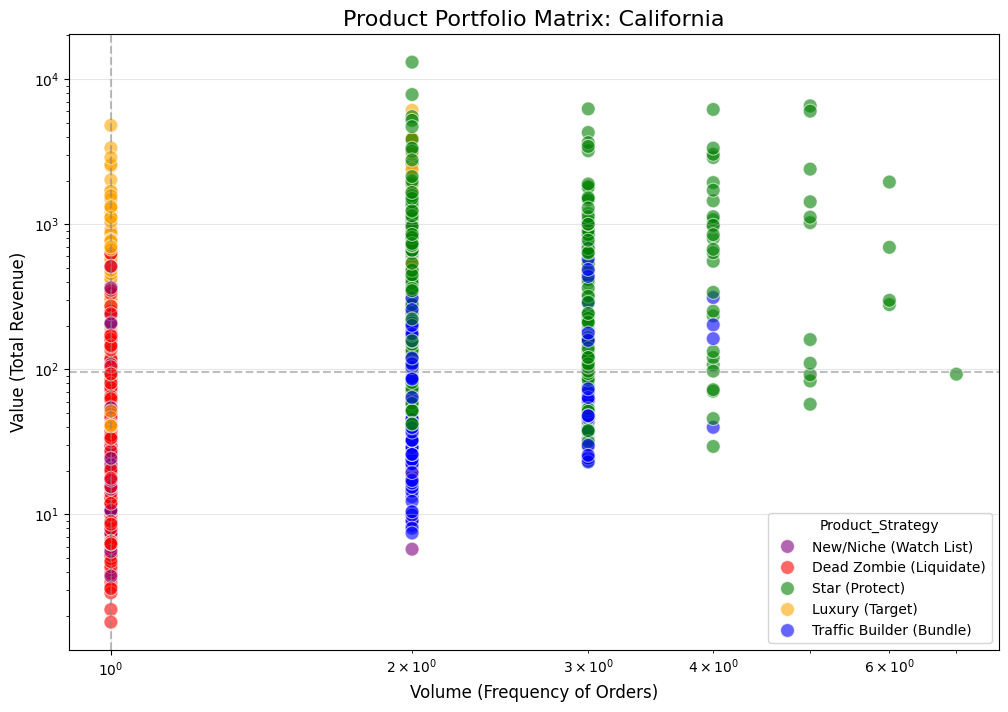

In [97]:
# Product Portfolio Matrix for West Focus States
product_stats = west_focus.groupby(['Sub-Category', 'Product Name']).agg({
    'Sales': 'sum',
    'Row ID': 'count',
    'Order Date': 'max'
}).reset_index()
product_stats.columns = ['Sub-Category', 'Product Name', 'Total_Sales', 'Line_Item_Freq', 'Last_Sale_Date']

max_date_west = west_focus['Order Date'].max()
product_stats['Recency_Days'] = (max_date_west - product_stats['Last_Sale_Date']).dt.days

product_stats['Category_Median_Sales'] = product_stats.groupby('Sub-Category')['Total_Sales'].transform('median')
product_stats['Category_Median_Freq'] = product_stats.groupby('Sub-Category')['Line_Item_Freq'].transform('median')

def classify_strategy(row):
    high_val = row['Total_Sales'] >= row['Category_Median_Sales']
    high_vol = row['Line_Item_Freq'] > row['Category_Median_Freq']
    is_recent = row['Recency_Days'] <= 180
    
    if high_val and high_vol:
        return 'Star (Protect)'
    elif high_val and not high_vol:
        return 'Luxury (Target)'
    elif not high_val and high_vol:
        return 'Traffic Builder (Bundle)'
    else:
        if is_recent:
            return 'New/Niche (Watch List)'
        else:
            return 'Dead Zombie (Liquidate)'

product_stats['Product_Strategy'] = product_stats.apply(classify_strategy, axis=1)

print("="*70)
print(f"STRATEGIC PRODUCT MATRIX: {focus_label}")
print("="*70)

for strategy in ['Star (Protect)', 'Luxury (Target)', 'Traffic Builder (Bundle)', 
                 'New/Niche (Watch List)', 'Dead Zombie (Liquidate)']:
    products = product_stats[product_stats['Product_Strategy'] == strategy]
    if not products.empty:
        print(f"\n{strategy.upper()} ({len(products)} products):")
        for _, p in products.head(5).iterrows():
            print(f"  • {p['Product Name'][:50]}: ${p['Total_Sales']:,.0f} | {p['Line_Item_Freq']:.0f} orders | {p['Recency_Days']} days ago")
        if len(products) > 5:
            print(f"  ... and {len(products) - 5} more")

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=product_stats,
    x='Line_Item_Freq', 
    y='Total_Sales',
    hue='Product_Strategy',
    palette={'Star (Protect)': 'green', 
             'Dead Zombie (Liquidate)': 'red', 
             'Luxury (Target)': 'orange', 
             'Traffic Builder (Bundle)': 'blue',
             'New/Niche (Watch List)': 'purple'},
    alpha=0.6,
    s=100
)

plt.title(f'Product Portfolio Matrix: {focus_label}', fontsize=16)
plt.xlabel('Volume (Frequency of Orders)', fontsize=12)
plt.ylabel('Value (Total Revenue)', fontsize=12)
plt.axvline(product_stats['Line_Item_Freq'].median(), color='grey', linestyle='--', alpha=0.5)
plt.axhline(product_stats['Total_Sales'].median(), color='grey', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.xscale('log') 
plt.yscale('log')
plt.show()

### Seasonality Analysis - West Focus States

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\2264680877.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  west_focus['Month'] = west_focus['Order Date'].dt.month
C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\2264680877.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  west_focus['Year'] = west_focus['Order Date'].dt.year


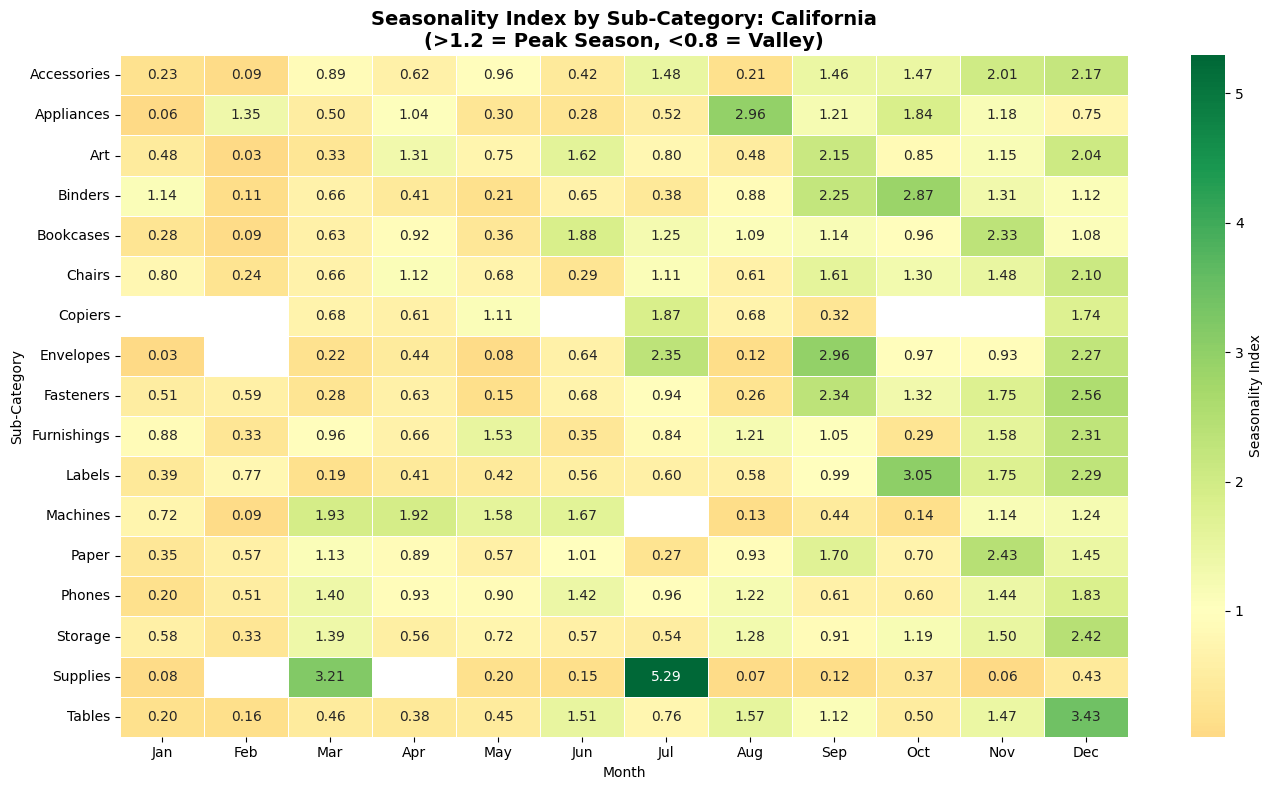


SEASONALITY INSIGHTS: California

Most Seasonal Products (High CV = High Variability):
Sub-Category         CV
    Supplies 178.763175
   Envelopes 104.297081
      Tables  92.272629
      Labels  89.008518
     Binders  83.105143

Most Stable Products (Low CV = Low Variability):
Sub-Category        CV
     Copiers 59.604108
 Furnishings 59.597671
     Storage 59.047455
      Chairs 55.695052
      Phones 47.368913


In [71]:
# Extract Month and Year
west_focus['Month'] = west_focus['Order Date'].dt.month
west_focus['Year'] = west_focus['Order Date'].dt.year

# Calculate Monthly Sales by Sub-Category
seasonality_data_west = west_focus.groupby(['Sub-Category', 'Month'])['Sales'].sum().reset_index()

# Calculate Seasonality Index (Monthly Sales / Average Monthly Sales)
avg_monthly_sales_west = seasonality_data_west.groupby('Sub-Category')['Sales'].mean().to_dict()
seasonality_data_west['Seasonality_Index'] = seasonality_data_west.apply(
    lambda row: row['Sales'] / avg_monthly_sales_west[row['Sub-Category']], axis=1
)

# Create pivot table for heatmap
seasonality_matrix_west = seasonality_data_west.pivot(index='Sub-Category', columns='Month', values='Seasonality_Index')

# Create ordered month labels
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasonality_matrix_west.columns = [month_order[int(m)-1] for m in seasonality_matrix_west.columns]

# Convert columns to categorical with proper order
seasonality_matrix_west = seasonality_matrix_west[month_order]

# Visualize Seasonality Index Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(seasonality_matrix_west, annot=True, fmt='.2f', cmap='RdYlGn', center=1.0, 
            cbar_kws={'label': 'Seasonality Index'}, linewidths=0.5)
plt.title(f'Seasonality Index by Sub-Category: {focus_label}\n(>1.2 = Peak Season, <0.8 = Valley)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Sub-Category')
plt.tight_layout()
plt.show()

# Summary Statistics
print("\n" + "="*70)
print(f"SEASONALITY INSIGHTS: {focus_label}")
print("="*70)

# Calculate Coefficient of Variation (CV) for each product
cv_scores_west = []
for subcategory in seasonality_matrix_west.index:
    values = seasonality_matrix_west.loc[subcategory].dropna()
    if len(values) > 0:
        cv = (values.std() / values.mean()) * 100
        cv_scores_west.append({'Sub-Category': subcategory, 'CV': cv})

cv_df_west = pd.DataFrame(cv_scores_west).sort_values('CV', ascending=False)

print("\nMost Seasonal Products (High CV = High Variability):")
print(cv_df_west.head(5).to_string(index=False))

print("\nMost Stable Products (Low CV = Low Variability):")
print(cv_df_west.tail(5).to_string(index=False))

## Central Region Analysis

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\4154511298.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=central_yearly_sales, x='Order Date', y='Sales', palette='Blues_d')


C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\4154511298.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=central_yearly_sales, x='Order Date', y='Sales', palette='Blues_d')


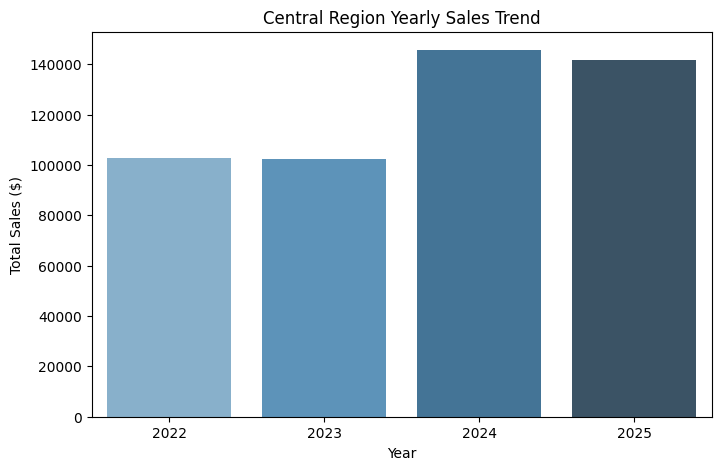

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\4154511298.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=central_yearly_sales, x='Order Date', y='Sales', palette='Blues_d')


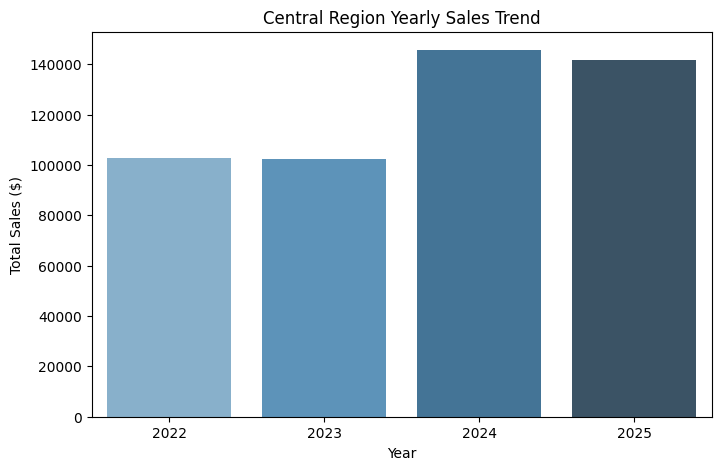

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\4154511298.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=central_sales_by_state, x='State', y='Sales', palette='Blues_d')


C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\4154511298.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=central_yearly_sales, x='Order Date', y='Sales', palette='Blues_d')


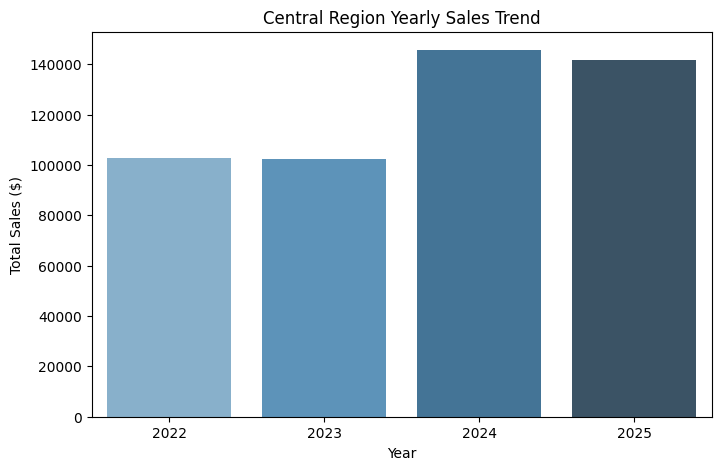

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\4154511298.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=central_sales_by_state, x='State', y='Sales', palette='Blues_d')


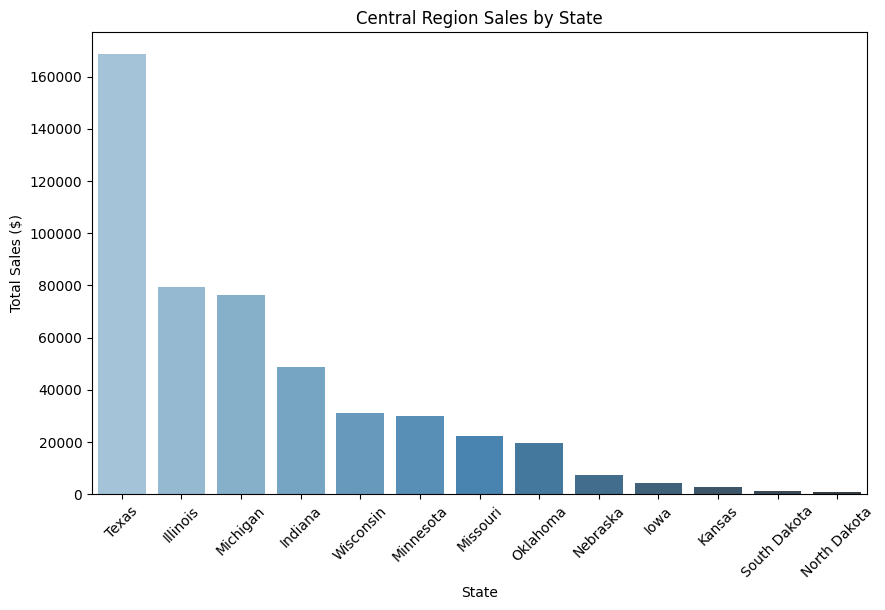

Top State: Texas ($168,572.53)
2nd State: Illinois ($79,236.52)
Ratio: 47.00%

→ Analyzing only Texas


In [98]:
central = df[df['Region'] == 'Central']
central_yearly_sales = central.groupby(central['Order Date'].dt.year)['Sales'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=central_yearly_sales, x='Order Date', y='Sales', palette='Blues_d')
plt.title('Central Region Yearly Sales Trend')
plt.xlabel('Year')
plt.ylabel('Total Sales ($)')
plt.show()

central_sales_by_state = central.groupby('State')['Sales'].sum().reset_index().sort_values(by='Sales', ascending=False)
central_sales_by_state['Proportion'] = (central_sales_by_state['Sales'] / central_sales_by_state['Sales'].sum()) * 100

plt.figure(figsize=(10, 6))
sns.barplot(data=central_sales_by_state, x='State', y='Sales', palette='Blues_d')
plt.title('Central Region Sales by State')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.ylabel('Total Sales ($)')
plt.show()

# Kingmaker Rule
top_state = central_sales_by_state.iloc[0]
second_state = central_sales_by_state.iloc[1]
ratio = second_state['Sales'] / top_state['Sales']

print(f"Top State: {top_state['State']} (${top_state['Sales']:,.2f})")
print(f"2nd State: {second_state['State']} (${second_state['Sales']:,.2f})")
print(f"Ratio: {ratio:.2%}\n")

if ratio >= 0.8:
    print(f"→ Analyzing both {top_state['State']} and {second_state['State']}")
    central_focus = central[central['State'].isin([top_state['State'], second_state['State']])]
    focus_label_central = f"{top_state['State']} + {second_state['State']}"
else:
    print(f"→ Analyzing only {top_state['State']}")
    central_focus = central[central['State'] == top_state['State']]
    focus_label_central = top_state['State']

### Strategic Product Classification - Central Focus States

Max line items per Order-Product combo: 2
→ Each row represents a unique line item

STRATEGIC PRODUCT MATRIX: Texas

STAR (PROTECT) (133 products):
  • Hypercom P1300 Pinpad: $252 | 2 orders | 739 days ago
  • Imation 16GB Mini TravelDrive USB 2.0 Flash Drive: $159 | 2 orders | 453 days ago
  • Kensington SlimBlade Notebook Wireless Mouse with : $320 | 2 orders | 276 days ago
  • Logitech 910-002974 M325 Wireless Mouse for Web Sc: $96 | 2 orders | 347 days ago
  • Logitech Desktop MK120 Mouse and keyboard Combo: $92 | 2 orders | 61 days ago
  ... and 128 more

LUXURY (TARGET) (249 products):
  • Case Logic 2.4GHz Wireless Keyboard: $120 | 1 orders | 1168 days ago
  • Enermax Acrylux Wireless Keyboard: $398 | 1 orders | 1090 days ago
  • Kensington Expert Mouse Optical USB Trackball for : $228 | 1 orders | 1350 days ago
  • Kensington Orbit Wireless Mobile Trackball for PC : $432 | 1 orders | 629 days ago
  • Logitech G105 Gaming Keyboard: $95 | 1 orders | 399 days ago
  ... and 244 mor

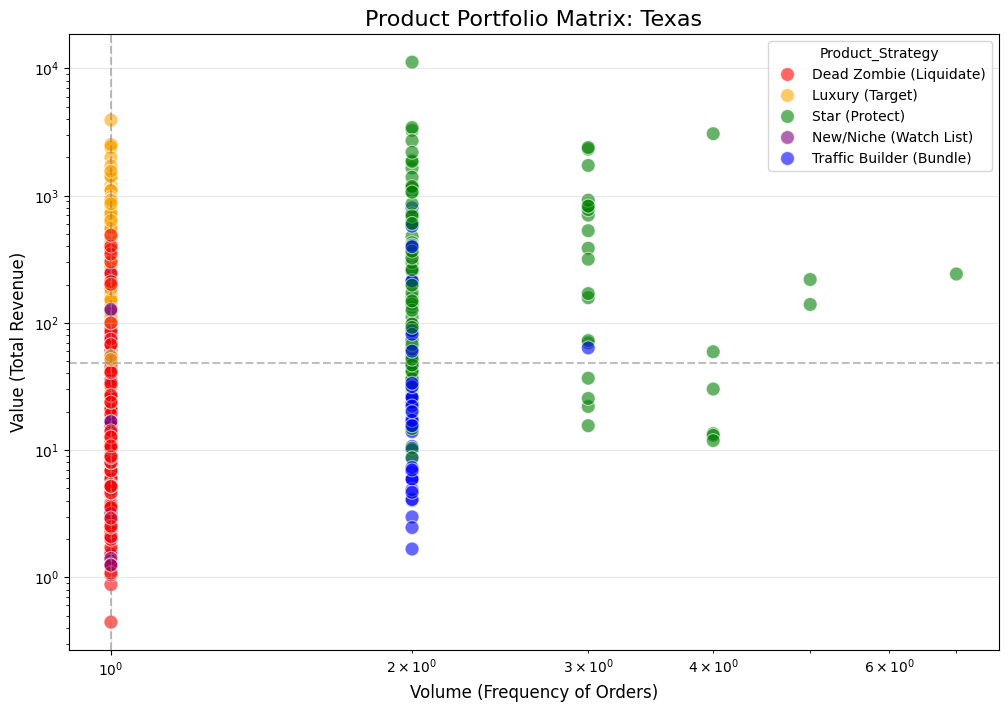

In [73]:
# Product Performance Analysis for Central Focus States (Product-Level Granularity)
# Confirm the dataset lists individual line items separately
duplicates = df.groupby(['Order ID', 'Product ID']).size()
print(f"Max line items per Order-Product combo: {duplicates.max()}")
print("→ Each row represents a unique line item\n")

# 1. Prepare the Data (Group by Sub-Category + Product)
product_stats = central_focus.groupby(['Sub-Category', 'Product Name']).agg({
    'Sales': 'sum',
    'Row ID': 'count',
    'Order Date': 'max'
}).reset_index()
product_stats.columns = ['Sub-Category', 'Product Name', 'Total_Sales', 'Line_Item_Freq', 'Last_Sale_Date']

# Get the most recent date in the dataset
max_date = central_focus['Order Date'].max()
# Calculate "Days Since Last Sale"
product_stats['Recency_Days'] = (max_date - product_stats['Last_Sale_Date']).dt.days

# 2. Calculate "Peer Medians" (The Relative Benchmarks)
product_stats['Category_Median_Sales'] = product_stats.groupby('Sub-Category')['Total_Sales'].transform('median')
product_stats['Category_Median_Freq'] = product_stats.groupby('Sub-Category')['Line_Item_Freq'].transform('median')

# 3. Apply classification logic
def classify_strategy(row):
    # 1. Determine if it is High Value / High Volume relative to peers
    high_val = row['Total_Sales'] >= row['Category_Median_Sales']
    high_vol = row['Line_Item_Freq'] > row['Category_Median_Freq'] # Strict > for volume
    
    # 2. Determine "Recency" (Is it New?)
    # If sold within the last 180 days (6 months), consider it "Recent"
    is_recent = row['Recency_Days'] <= 180 
    
    # 3. Assign the Strategy Label
    if high_val and high_vol:
        return 'Star (Protect)'
        
    elif high_val and not high_vol:
        return 'Luxury (Target)'
        
    elif not high_val and high_vol:
        return 'Traffic Builder (Bundle)'
        
    else:
        # It is in the "Bottom Left" (Low Sales / Low Vol)
        # This is where we split the Zombies!
        if is_recent:
            return 'New/Niche (Watch List)'  # It's weak, but it's NEW. Keep it.
        else:
            return 'Dead Zombie (Liquidate)' # It's weak AND OLD. Kill it.

product_stats['Product_Strategy'] = product_stats.apply(classify_strategy, axis=1)

# 4. Display Classification Results
print("="*70)
print(f"STRATEGIC PRODUCT MATRIX: {focus_label_central}")
print("="*70)

for strategy in ['Star (Protect)', 'Luxury (Target)', 'Traffic Builder (Bundle)', 
                 'New/Niche (Watch List)', 'Dead Zombie (Liquidate)']:
    products = product_stats[product_stats['Product_Strategy'] == strategy]
    if not products.empty:
        print(f"\n{strategy.upper()} ({len(products)} products):")
        for _, p in products.head(5).iterrows():  # Show top 5 per category
            print(f"  • {p['Product Name'][:50]}: ${p['Total_Sales']:,.0f} | {p['Line_Item_Freq']:.0f} orders | {p['Recency_Days']} days ago")
        if len(products) > 5:
            print(f"  ... and {len(products) - 5} more")

plt.show()

# 5. Visualization: The "ProductStrategy Matrix" Scatter Plot

plt.figure(figsize=(12, 8))
plt.xscale('log')  # Log scale helps if you have "Whale" products that squash the chart
plt.yscale('log')

sns.scatterplot(
    data=product_stats,
    x='Line_Item_Freq', 
    y='Total_Sales',
    hue='Product_Strategy',
    palette={'Star (Protect)': 'green', 
             'Dead Zombie (Liquidate)': 'red', 
             'Luxury (Target)': 'orange', 
             'Traffic Builder (Bundle)': 'blue',
             'New/Niche (Watch List)': 'purple'},
    alpha=0.6,
    s=100
)

plt.grid(True, alpha=0.3)
plt.axhline(product_stats['Total_Sales'].median(), color='grey', linestyle='--', alpha=0.5)
plt.axvline(product_stats['Line_Item_Freq'].median(), color='grey', linestyle='--', alpha=0.5)
plt.ylabel('Value (Total Revenue)', fontsize=12)
plt.xlabel('Volume (Frequency of Orders)', fontsize=12)
plt.title(f'Product Portfolio Matrix: {focus_label_central}', fontsize=16)
plt.show()

### Seasonality Analysis - Central Focus States

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\1864610996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  central_focus['Month'] = central_focus['Order Date'].dt.month
C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\1864610996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  central_focus['Year'] = central_focus['Order Date'].dt.year


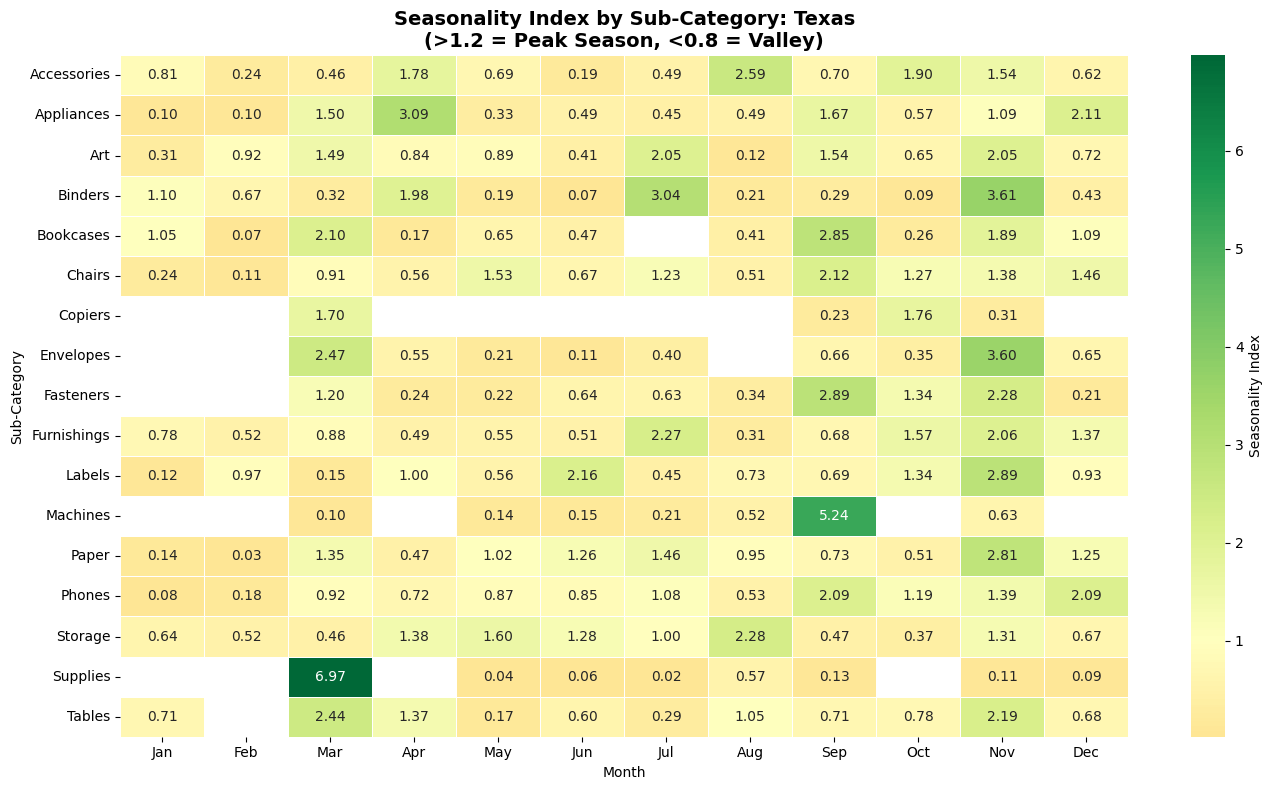


SEASONALITY INSIGHTS: Texas

Most Seasonal Products (High CV = High Variability):
Sub-Category         CV
    Supplies 241.991673
    Machines 188.147086
     Binders 122.023408
   Envelopes 120.157882
   Fasteners  93.737161

Most Stable Products (Low CV = Low Variability):
Sub-Category        CV
 Furnishings 65.895020
         Art 64.494592
      Phones 63.586500
      Chairs 59.954104
     Storage 58.449593


In [74]:
# Extract Month and Year
central_focus['Month'] = central_focus['Order Date'].dt.month
central_focus['Year'] = central_focus['Order Date'].dt.year

# Calculate Monthly Sales by Sub-Category
seasonality_data_central = central_focus.groupby(['Sub-Category', 'Month'])['Sales'].sum().reset_index()

# Calculate Seasonality Index (Monthly Sales / Average Monthly Sales)
avg_monthly_sales_central = seasonality_data_central.groupby('Sub-Category')['Sales'].mean().to_dict()
seasonality_data_central['Seasonality_Index'] = seasonality_data_central.apply(
    lambda row: row['Sales'] / avg_monthly_sales_central[row['Sub-Category']], axis=1
)

# Create pivot table for heatmap
seasonality_matrix_central = seasonality_data_central.pivot(index='Sub-Category', columns='Month', values='Seasonality_Index')

# Create ordered month labels
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasonality_matrix_central.columns = [month_order[int(m)-1] for m in seasonality_matrix_central.columns]

# Convert columns to categorical with proper order
seasonality_matrix_central = seasonality_matrix_central[month_order]

# Visualize Seasonality Index Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(seasonality_matrix_central, annot=True, fmt='.2f', cmap='RdYlGn', center=1.0, 
            cbar_kws={'label': 'Seasonality Index'}, linewidths=0.5)
plt.title(f'Seasonality Index by Sub-Category: {focus_label_central}\n(>1.2 = Peak Season, <0.8 = Valley)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Sub-Category')
plt.tight_layout()
plt.show()

# Summary Statistics
print("\n" + "="*70)
print(f"SEASONALITY INSIGHTS: {focus_label_central}")
print("="*70)

# Calculate Coefficient of Variation (CV) for each product
cv_scores_central = []
for subcategory in seasonality_matrix_central.index:
    values = seasonality_matrix_central.loc[subcategory].dropna()
    if len(values) > 0:
        cv = (values.std() / values.mean()) * 100
        cv_scores_central.append({'Sub-Category': subcategory, 'CV': cv})

cv_df_central = pd.DataFrame(cv_scores_central).sort_values('CV', ascending=False)

print("\nMost Seasonal Products (High CV = High Variability):")
print(cv_df_central.head(5).to_string(index=False))

print("\nMost Stable Products (Low CV = Low Variability):")
print(cv_df_central.tail(5).to_string(index=False))

## South Region Analysis

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\3007119393.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=south_yearly_sales, x='Order Date', y='Sales', palette='Oranges_d')


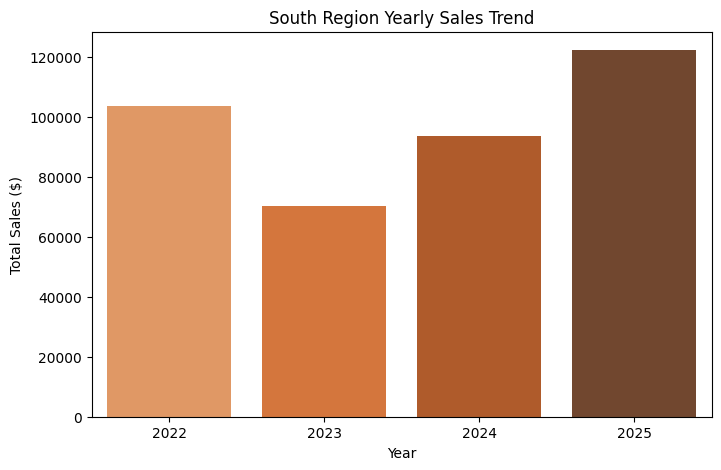

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\3007119393.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=south_yearly_sales, x='Order Date', y='Sales', palette='Oranges_d')


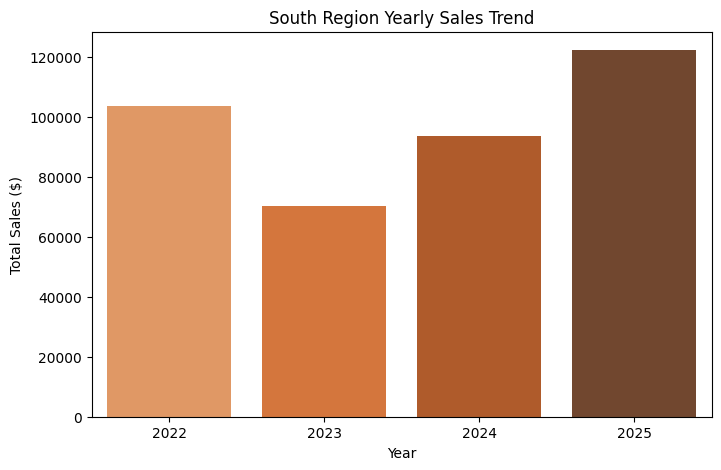

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\3007119393.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=south_sales_by_state, x='State', y='Sales', palette='Oranges_d')


C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\3007119393.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=south_yearly_sales, x='Order Date', y='Sales', palette='Oranges_d')


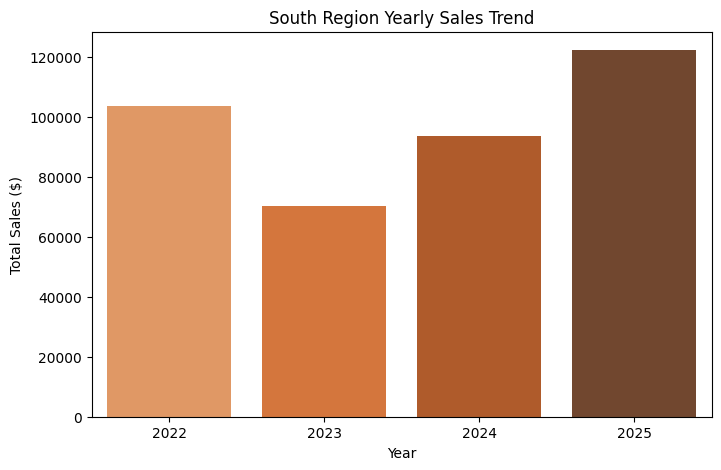

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\3007119393.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=south_sales_by_state, x='State', y='Sales', palette='Oranges_d')


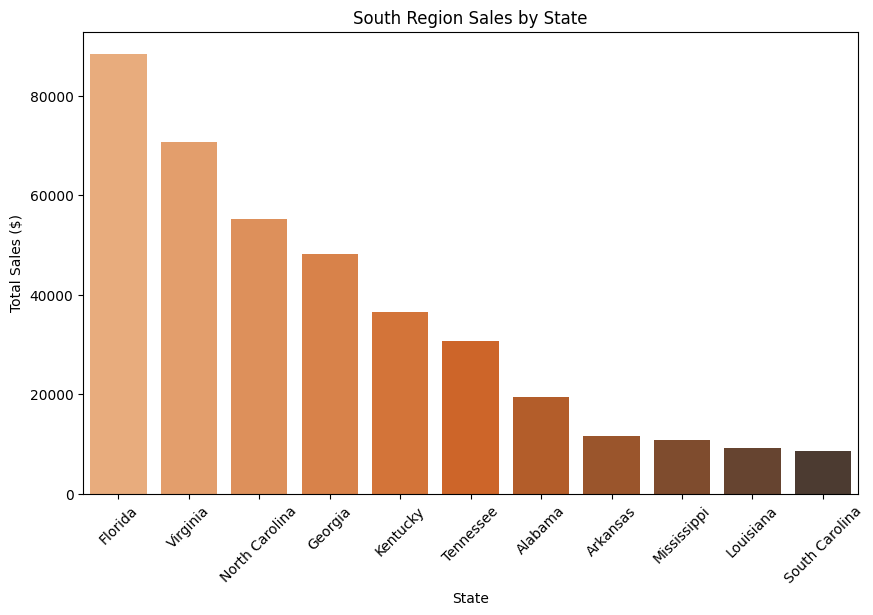

Top State: Florida ($88,436.53)
2nd State: Virginia ($70,636.72)
Ratio: 79.87%

→ Analyzing only Florida


In [99]:
south = df[df['Region'] == 'South']
south_yearly_sales = south.groupby(south['Order Date'].dt.year)['Sales'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=south_yearly_sales, x='Order Date', y='Sales', palette='Oranges_d')
plt.title('South Region Yearly Sales Trend')
plt.xlabel('Year')
plt.ylabel('Total Sales ($)')
plt.show()

south_sales_by_state = south.groupby('State')['Sales'].sum().reset_index().sort_values(by='Sales', ascending=False)
south_sales_by_state['Proportion'] = (south_sales_by_state['Sales'] / south_sales_by_state['Sales'].sum()) * 100

plt.figure(figsize=(10, 6))
sns.barplot(data=south_sales_by_state, x='State', y='Sales', palette='Oranges_d')
plt.title('South Region Sales by State')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.ylabel('Total Sales ($)')
plt.show()

# Kingmaker Rule
top_state = south_sales_by_state.iloc[0]
second_state = south_sales_by_state.iloc[1]
ratio = second_state['Sales'] / top_state['Sales']

print(f"Top State: {top_state['State']} (${top_state['Sales']:,.2f})")
print(f"2nd State: {second_state['State']} (${second_state['Sales']:,.2f})")
print(f"Ratio: {ratio:.2%}\n")

if ratio >= 0.8:
    print(f"→ Analyzing both {top_state['State']} and {second_state['State']}")
    south_focus = south[south['State'].isin([top_state['State'], second_state['State']])]
    focus_label_south = f"{top_state['State']} + {second_state['State']}"
else:
    print(f"→ Analyzing only {top_state['State']}")
    south_focus = south[south['State'] == top_state['State']]
    focus_label_south = top_state['State']

### Strategic Product Classification - South Focus States

STRATEGIC PRODUCT MATRIX: Florida

STAR (PROTECT) (28 products):
  • Logitech G602 Wireless Gaming Mouse: $640 | 2 orders | 46 days ago
  • Logitech P710e Mobile Speakerphone: $824 | 2 orders | 205 days ago
  • Acco 7-Outlet Masterpiece Power Center, Wihtout Fa: $584 | 2 orders | 37 days ago
  • Bulldog Vacuum Base Pencil Sharpener: $96 | 2 orders | 23 days ago
  • Crayola Colored Pencils: $16 | 2 orders | 974 days ago
  ... and 23 more

LUXURY (TARGET) (143 products):
  • Belkin QODE FastFit Bluetooth Keyboard: $248 | 1 orders | 1102 days ago
  • Enermax Acrylux Wireless Keyboard: $717 | 1 orders | 829 days ago
  • Logitech Wireless Anywhere Mouse MX for PC and Mac: $336 | 1 orders | 1354 days ago
  • Logitech Wireless Gaming Headset G930: $384 | 1 orders | 1354 days ago
  • Logitech MX Performance Wireless Mouse: $191 | 1 orders | 720 days ago
  ... and 138 more

TRAFFIC BUILDER (BUNDLE) (11 products):
  • Eureka Sanitaire  Multi-Pro Heavy-Duty Upright, Di: $31 | 2 orders | 205 days 

STRATEGIC PRODUCT MATRIX: Florida

STAR (PROTECT) (28 products):
  • Logitech G602 Wireless Gaming Mouse: $640 | 2 orders | 46 days ago
  • Logitech P710e Mobile Speakerphone: $824 | 2 orders | 205 days ago
  • Acco 7-Outlet Masterpiece Power Center, Wihtout Fa: $584 | 2 orders | 37 days ago
  • Bulldog Vacuum Base Pencil Sharpener: $96 | 2 orders | 23 days ago
  • Crayola Colored Pencils: $16 | 2 orders | 974 days ago
  ... and 23 more

LUXURY (TARGET) (143 products):
  • Belkin QODE FastFit Bluetooth Keyboard: $248 | 1 orders | 1102 days ago
  • Enermax Acrylux Wireless Keyboard: $717 | 1 orders | 829 days ago
  • Logitech Wireless Anywhere Mouse MX for PC and Mac: $336 | 1 orders | 1354 days ago
  • Logitech Wireless Gaming Headset G930: $384 | 1 orders | 1354 days ago
  • Logitech MX Performance Wireless Mouse: $191 | 1 orders | 720 days ago
  ... and 138 more

TRAFFIC BUILDER (BUNDLE) (11 products):
  • Eureka Sanitaire  Multi-Pro Heavy-Duty Upright, Di: $31 | 2 orders | 205 days 

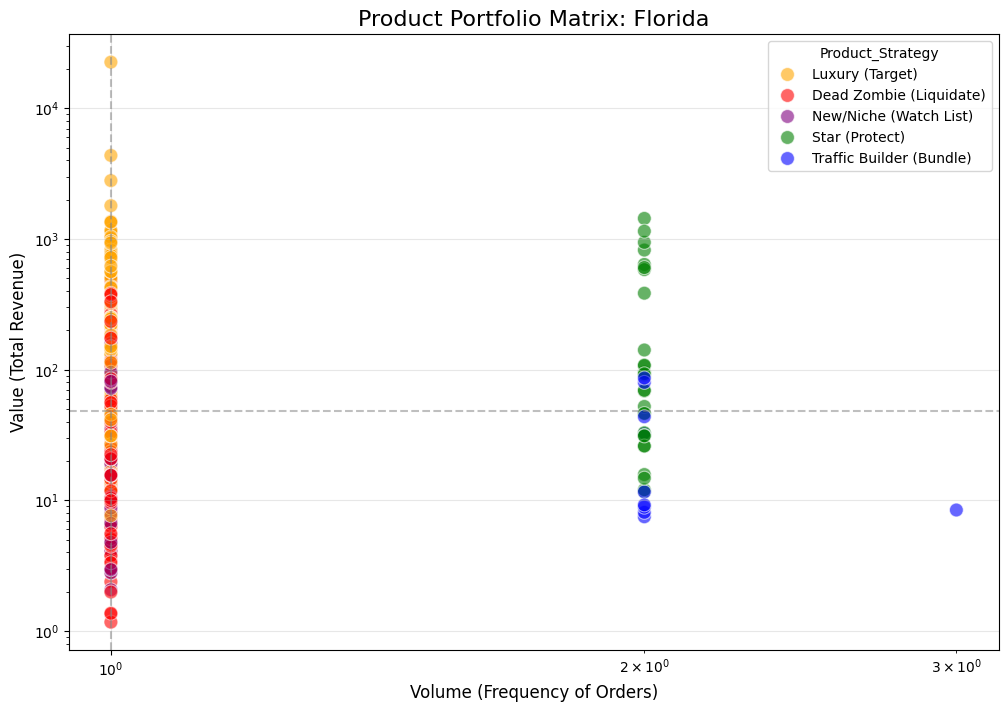

In [100]:
# Product Portfolio Matrix for South Focus States
product_stats = south_focus.groupby(['Sub-Category', 'Product Name']).agg({
    'Sales': 'sum',
    'Row ID': 'count',
    'Order Date': 'max'
}).reset_index()
product_stats.columns = ['Sub-Category', 'Product Name', 'Total_Sales', 'Line_Item_Freq', 'Last_Sale_Date']

max_date_south = south_focus['Order Date'].max()
product_stats['Recency_Days'] = (max_date_south - product_stats['Last_Sale_Date']).dt.days

product_stats['Category_Median_Sales'] = product_stats.groupby('Sub-Category')['Total_Sales'].transform('median')
product_stats['Category_Median_Freq'] = product_stats.groupby('Sub-Category')['Line_Item_Freq'].transform('median')

def classify_strategy(row):
    high_val = row['Total_Sales'] >= row['Category_Median_Sales']
    high_vol = row['Line_Item_Freq'] > row['Category_Median_Freq']
    is_recent = row['Recency_Days'] <= 180
    
    if high_val and high_vol:
        return 'Star (Protect)'
    elif high_val and not high_vol:
        return 'Luxury (Target)'
    elif not high_val and high_vol:
        return 'Traffic Builder (Bundle)'
    else:
        if is_recent:
            return 'New/Niche (Watch List)'
        else:
            return 'Dead Zombie (Liquidate)'

product_stats['Product_Strategy'] = product_stats.apply(classify_strategy, axis=1)

print("="*70)
print(f"STRATEGIC PRODUCT MATRIX: {focus_label_south}")
print("="*70)

for strategy in ['Star (Protect)', 'Luxury (Target)', 'Traffic Builder (Bundle)', 
                 'New/Niche (Watch List)', 'Dead Zombie (Liquidate)']:
    products = product_stats[product_stats['Product_Strategy'] == strategy]
    if not products.empty:
        print(f"\n{strategy.upper()} ({len(products)} products):")
        for _, p in products.head(5).iterrows():
            print(f"  • {p['Product Name'][:50]}: ${p['Total_Sales']:,.0f} | {p['Line_Item_Freq']:.0f} orders | {p['Recency_Days']} days ago")
        if len(products) > 5:
            print(f"  ... and {len(products) - 5} more")

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=product_stats,
    x='Line_Item_Freq', 
    y='Total_Sales',
    hue='Product_Strategy',
    palette={'Star (Protect)': 'green', 
             'Dead Zombie (Liquidate)': 'red', 
             'Luxury (Target)': 'orange', 
             'Traffic Builder (Bundle)': 'blue',
             'New/Niche (Watch List)': 'purple'},
    alpha=0.6,
    s=100
)

plt.title(f'Product Portfolio Matrix: {focus_label_south}', fontsize=16)
plt.xlabel('Volume (Frequency of Orders)', fontsize=12)
plt.ylabel('Value (Total Revenue)', fontsize=12)
plt.axvline(product_stats['Line_Item_Freq'].median(), color='grey', linestyle='--', alpha=0.5)
plt.axhline(product_stats['Total_Sales'].median(), color='grey', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.xscale('log') 
plt.yscale('log')
plt.show()

### Seasonality Analysis - South Focus States

C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\106301361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  south_focus['Month'] = south_focus['Order Date'].dt.month
C:\Users\osaze\AppData\Local\Temp\ipykernel_36504\106301361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  south_focus['Year'] = south_focus['Order Date'].dt.year


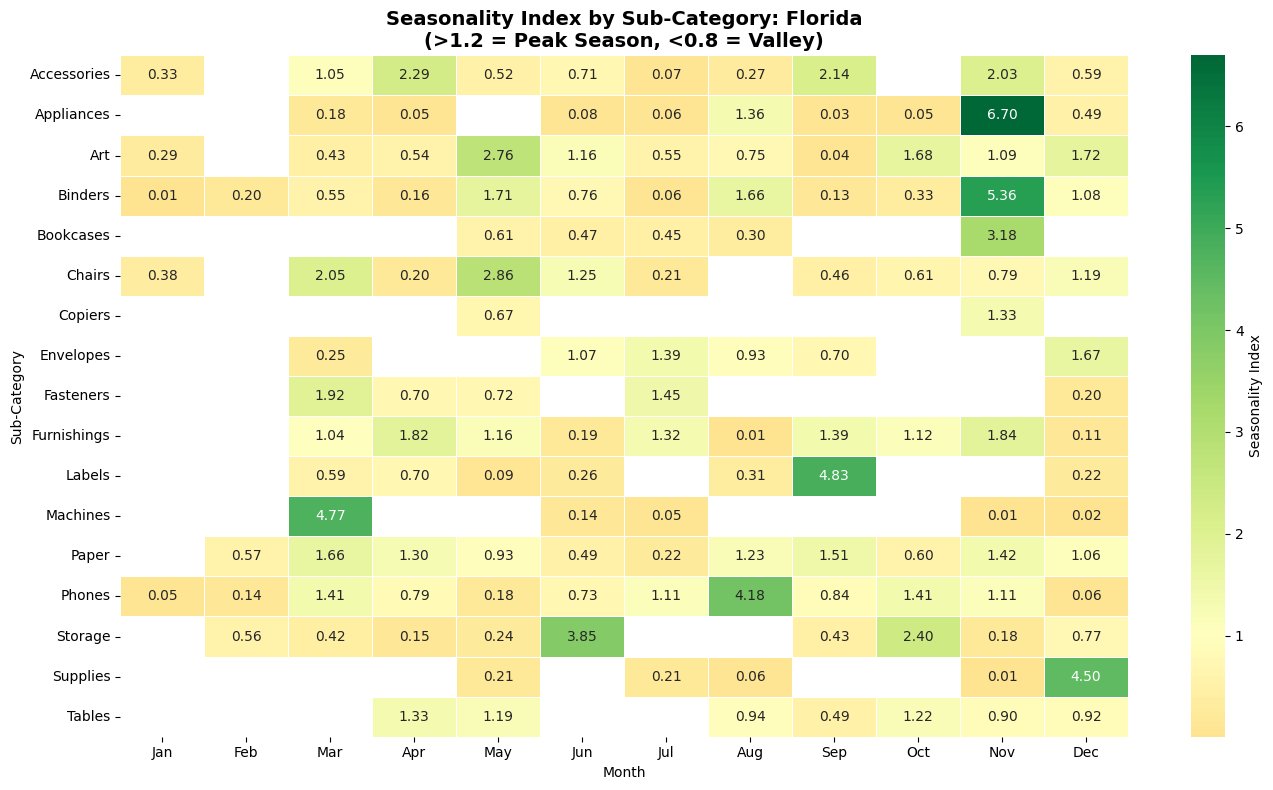


SEASONALITY INSIGHTS: Florida

Most Seasonal Products (High CV = High Variability):
Sub-Category         CV
  Appliances 217.978673
    Machines 210.997822
    Supplies 195.953494
      Labels 170.359318
     Binders 149.620428

Most Stable Products (Low CV = Low Variability):
Sub-Category        CV
 Furnishings 67.530339
   Envelopes 50.346138
       Paper 47.296094
     Copiers 47.141500
      Tables 28.232651


In [77]:
# Extract Month and Year
south_focus['Month'] = south_focus['Order Date'].dt.month
south_focus['Year'] = south_focus['Order Date'].dt.year

# Calculate Monthly Sales by Sub-Category
seasonality_data_south = south_focus.groupby(['Sub-Category', 'Month'])['Sales'].sum().reset_index()

# Calculate Seasonality Index (Monthly Sales / Average Monthly Sales)
avg_monthly_sales_south = seasonality_data_south.groupby('Sub-Category')['Sales'].mean().to_dict()
seasonality_data_south['Seasonality_Index'] = seasonality_data_south.apply(
    lambda row: row['Sales'] / avg_monthly_sales_south[row['Sub-Category']], axis=1
)

# Create pivot table for heatmap
seasonality_matrix_south = seasonality_data_south.pivot(index='Sub-Category', columns='Month', values='Seasonality_Index')

# Create ordered month labels
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasonality_matrix_south.columns = [month_order[int(m)-1] for m in seasonality_matrix_south.columns]

# Convert columns to categorical with proper order
seasonality_matrix_south = seasonality_matrix_south[month_order]

# Visualize Seasonality Index Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(seasonality_matrix_south, annot=True, fmt='.2f', cmap='RdYlGn', center=1.0, 
            cbar_kws={'label': 'Seasonality Index'}, linewidths=0.5)
plt.title(f'Seasonality Index by Sub-Category: {focus_label_south}\n(>1.2 = Peak Season, <0.8 = Valley)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Sub-Category')
plt.tight_layout()
plt.show()

# Summary Statistics
print("\n" + "="*70)
print(f"SEASONALITY INSIGHTS: {focus_label_south}")
print("="*70)

# Calculate Coefficient of Variation (CV) for each product
cv_scores_south = []
for subcategory in seasonality_matrix_south.index:
    values = seasonality_matrix_south.loc[subcategory].dropna()
    if len(values) > 0:
        cv = (values.std() / values.mean()) * 100
        cv_scores_south.append({'Sub-Category': subcategory, 'CV': cv})

cv_df_south = pd.DataFrame(cv_scores_south).sort_values('CV', ascending=False)

print("\nMost Seasonal Products (High CV = High Variability):")
print(cv_df_south.head(5).to_string(index=False))

print("\nMost Stable Products (Low CV = Low Variability):")
print(cv_df_south.tail(5).to_string(index=False))